<a href="https://colab.research.google.com/github/let-aranha/ttc-bi-master/blob/main/TCC_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução
O trabalho de conclusão de curso tem como objetivo construir um modelo capaz de prever a classe de saída dos chamados abertos pelos clientes da plataforma de ecommerce VTEX de acordo com quatro níveis de complexidades já existentes: *"Low", "Moderate", "High"* e *"Very High".*
<br>
<br>
O modelo utiliza como base dados estruturados obtidos através da plataforma Zendesk, canal oficial de comunicação do suporte VTEX. O dataset comtempla:


1.   Dados anonimizados pertinentes à organização, como ID, informações de Customer Success Manager, Partner e NPS;
2.   Dados anonimizados pertinentes ao usuário responsável pela abertura do chamado, como ID, nível de conhecimento da plataforma VTEX e data de cadastro;
3.   Dados relativos ao funcionamento do ecommerce;
4.   Informações da própria criação do chamado, como data e hora de criação, tipo do chamado e prioridade.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/My Drive/TCC/Dataset'
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importando json

import json 
import pandas as pd
import numpy as np

f = open('tickets_anonymized_Rev2.json', encoding='utf-8') 
data = json.load(f) 
 
f.close() 

In [ ]:
dataset = pd.DataFrame(data)
dataset.set_index('id', inplace = True)
dataset.head()

,created_at,type,priority,status,is_public,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating
id,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,incident,high,hold,True,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None
166035,2019-06-12T15:23:14.000Z,incident,high,open,True,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None
182449,2019-08-23T21:13:47.000Z,question,normal,hold,True,144968,379450971772,3.600155e+11,2.559354e+08,False,False,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None
189041,2019-09-20T16:33:59.000Z,incident,normal,solved,True,144968,378569033032,3.600120e+11,1.403345e+08,True,False,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None
207873,2019-12-09T13:54:47.000Z,None,normal,open,True,144968,367450009112,3.600124e+11,3.600242e+11,False,False,367450009112,2018-07-25T06:41:31.000Z,None,platform-skills-advanced,None,None


## Verificando tipos de dados

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22653 entries, 162875 to 346442
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 22653 non-null  object 
 1   type                       17636 non-null  object 
 2   priority                   22653 non-null  object 
 3   status                     22653 non-null  object 
 4   is_public                  22653 non-null  bool   
 5   brand_id                   22653 non-null  int64  
 6   submitter_id               22653 non-null  int64  
 7   group_id                   22545 non-null  float64
 8   organization_id            18220 non-null  float64
 9   has_partner                18220 non-null  object 
 10  has_success_manager        18220 non-null  object 
 11  requester_id               22653 non-null  int64  
 12  requester_created_at       22653 non-null  object 
 13  requester_nps              2837 non-null

# Análise Exploratória

Método de análise preliminar da base de dados para compreensão básica da estrutura dos dados e identificação de padrões existentes entre as variáveis.

In [ ]:
# Importação dos pacotes

import random
import matplotlib.pyplot as plt
import seaborn as sns

# Definição de parâmetros para a criação de gráficos
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (15,10)

In [ ]:
dataset.shape

(22653, 17)

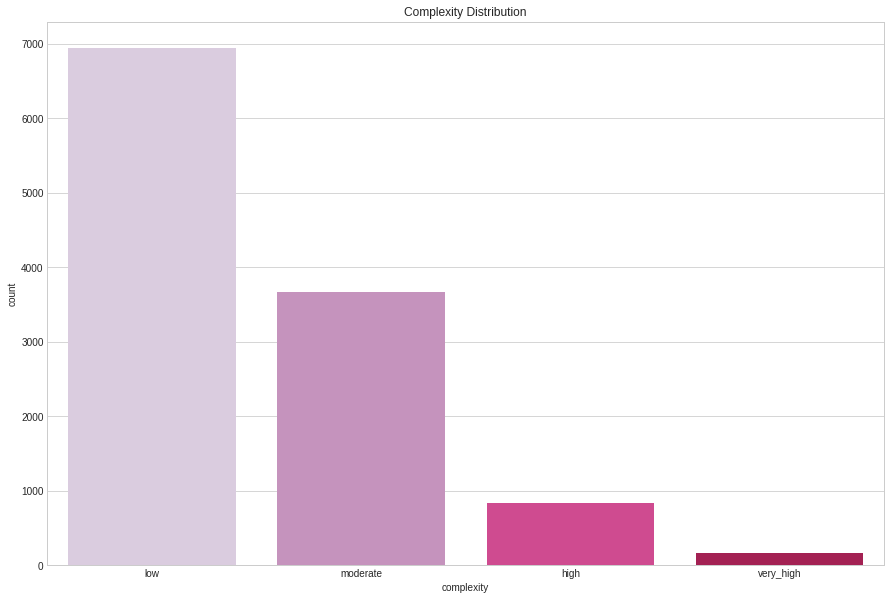

In [ ]:
# Análise balanceamento

sns.countplot(data=dataset, x='complexity', order=['low','moderate','high','very_high'], palette='PuRd')
plt.title('Complexity Distribution')
# plt.savefig('Classe-Saída-sem-limpeza-de-dados.png')
plt.show()

In [ ]:
from collections import Counter
print('Original dataset shape %s' % Counter(dataset['complexity']))

Original dataset shape Counter({None: 10887, 'low': 6948, 'moderate': 3672, 'high': 831, 'very_high': 164, '': 151})


In [ ]:
# Cálculo de porcentual de valores nulos na base

(len(dataset[dataset['complexity'] == '']) + dataset['complexity'].isnull().sum())/len(dataset['complexity'])*100

48.726437999381986

A variável "complexity", classe de saída do modelo, possui um número considerável de valores nulos.
<br>
Neste caso, optou-se pela exclusão das entradas sem classe de saída, ao invés da substituição pela moda, para não causar um viés na interpretação dos dados, uma vez que o total de valores nulos ultrapassa a casa de 48% do total da base.

In [ ]:
# Limpando missing values e dados nulos da coluna de classificação

dataset = dataset.dropna(subset=['complexity'])
dataset = dataset[dataset['complexity'] != '']

In [ ]:
# Contagem das classes de saída

unique, counts = np.unique(dataset['complexity'], return_counts=True)

for i in range(len(unique)):
  print(f'Total de {unique[i]}: {counts[i]}')

Total de high: 831
Total de low: 6948
Total de moderate: 3672
Total de very_high: 164


In [ ]:
dataset.shape

(11615, 17)

In [ ]:
# Número de tickets por organization_id

count_org = dataset.groupby('organization_id')['organization_id'].count()
count_org.sort_values(ascending = False)

organization_id
4.280621e+07    145
4.280793e+07    100
3.601143e+11     83
1.403368e+08     79
4.280670e+07     76
               ... 
3.610910e+11      1
3.610912e+11      1
3.610923e+11      1
1.151714e+11      1
3.613654e+11      1
Name: organization_id, Length: 2597, dtype: int64

In [ ]:
# Números de tickets por group_id

dataset[u'group_id'].value_counts()

3.600088e+11    3629
3.600139e+11     474
3.600139e+11     434
3.600116e+11     413
3.600139e+11     411
                ... 
3.600057e+11       1
3.600114e+11       1
3.600003e+11       1
2.595627e+07       1
3.600060e+11       1
Name: group_id, Length: 91, dtype: int64

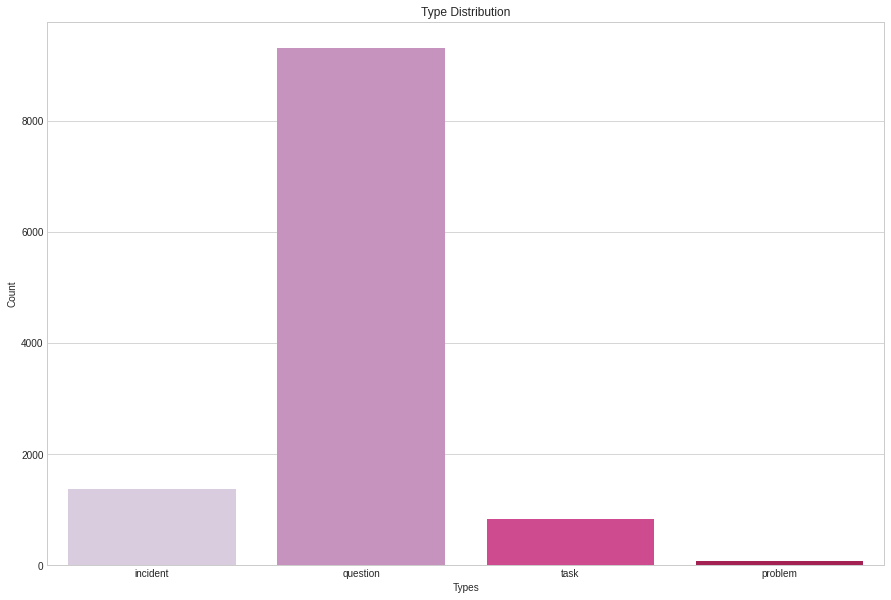

In [ ]:
sns.countplot(x="type", data=dataset, palette='PuRd')
plt.title('Type Distribution')
plt.xlabel('Types')
plt.ylabel('Count')
# plt.savefig('Tipos-de-tickets.png')
plt.show()

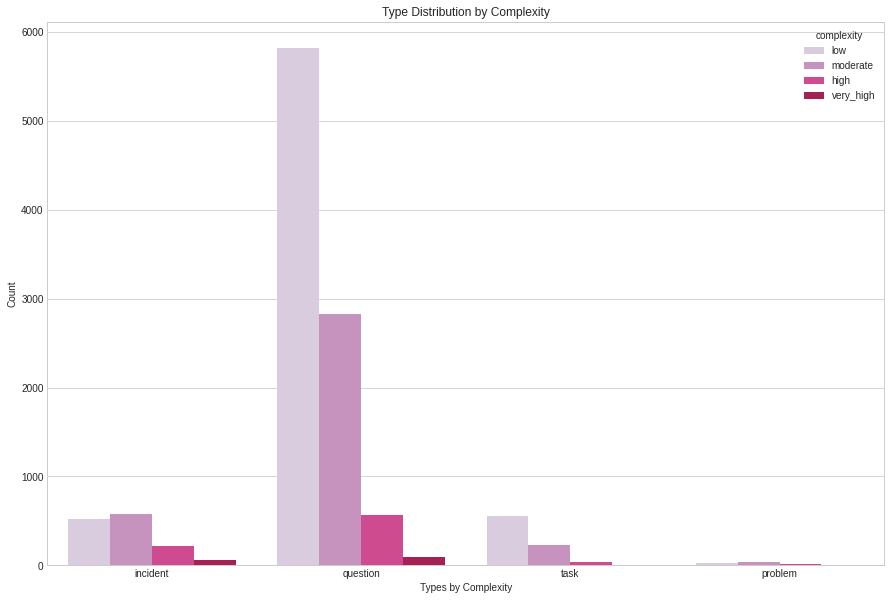

In [ ]:
sns.countplot(x="type", data=dataset,hue='complexity', hue_order=['low','moderate','high','very_high'], palette='PuRd')
plt.title('Type Distribution by Complexity')
plt.xlabel('Types by Complexity')
plt.ylabel('Count')
# plt.savefig('Tipos-de-tickets-por-complexidade.png')
plt.show()

Apesar do tipo "question" possuir a maioria de chamados com classificação "low", não é possível observar nenhum padrão que determine a aparição das classes minoritárias.

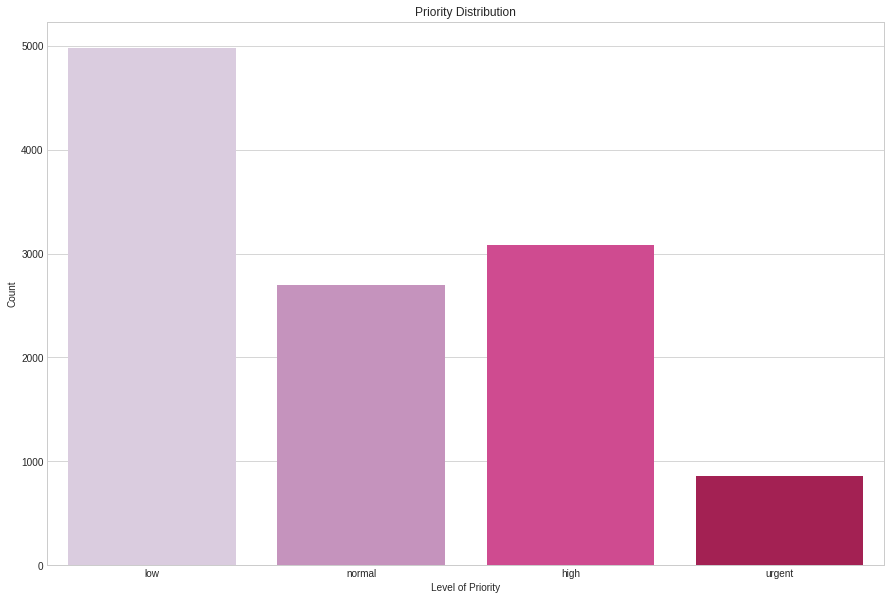

In [ ]:
sns.countplot(x="priority", data=dataset, order=['low','normal','high','urgent'],palette='PuRd')
plt.title('Priority Distribution')
plt.xlabel('Level of Priority')
plt.ylabel('Count')
# plt.savefig('Contagem-de-ticket-por-prioridade.png')
plt.show()

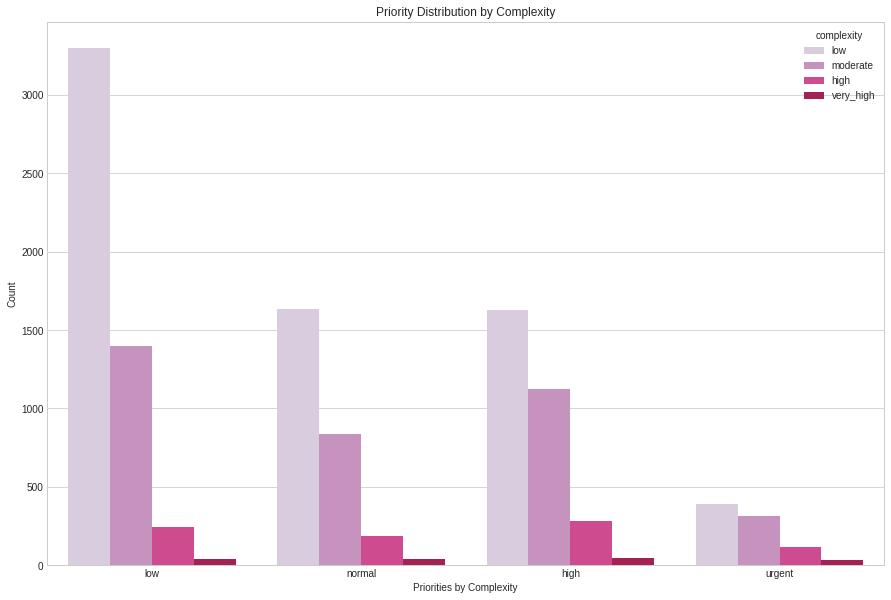

In [ ]:
sns.countplot(x="priority", data=dataset,hue='complexity',order=['low','normal','high','urgent'],
              hue_order=['low','moderate','high','very_high'], palette='PuRd')
plt.title('Priority Distribution by Complexity')
plt.xlabel('Priorities by Complexity')
plt.ylabel('Count')
# plt.savefig('Prioridades-por-complexidade.png')
plt.show()

O mesmo é possível afirmar para a variável que determina a prioridade dos chamados.<br>
Existe uma correlação evidente entre chamados de baixa complexidade e baixa prioridade, mas não é possível observar nenhum padrão que dite as ocorrências de tickets mais complexos.<br>
Poderíamos imaginar que chamados urgentes teriam esse efeito, mas como é possível observar acima, a ocorrência de tickets de alta complexidade é praticamente uniforme para todas as prioridades.

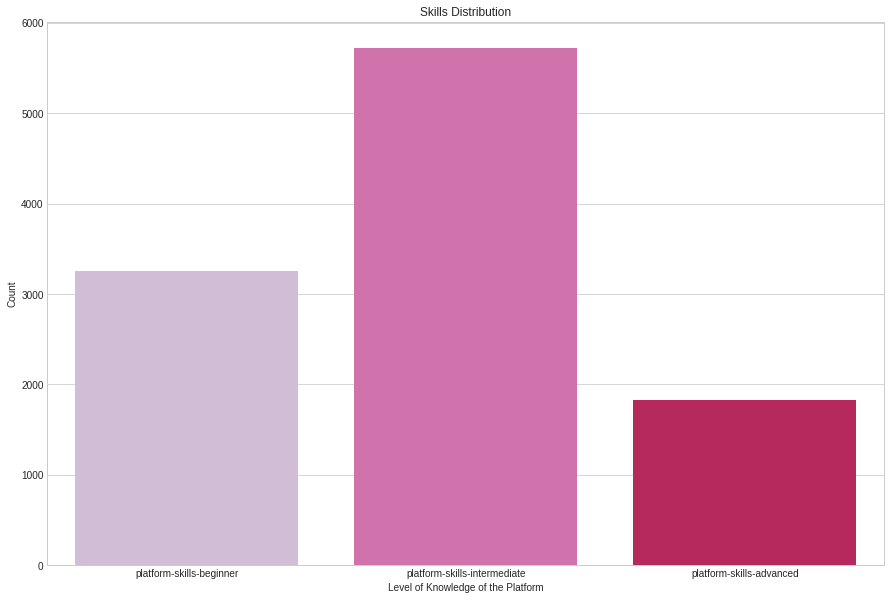

In [ ]:
sns.countplot(x="requester_platform_skills", data=dataset,
              order=['platform-skills-beginner','platform-skills-intermediate','platform-skills-advanced'], palette='PuRd')
plt.title('Skills Distribution')
plt.xlabel('Level of Knowledge of the Platform')
plt.ylabel('Count')
# plt.savefig('Distribuicao-plataform-skills.png')
plt.show()

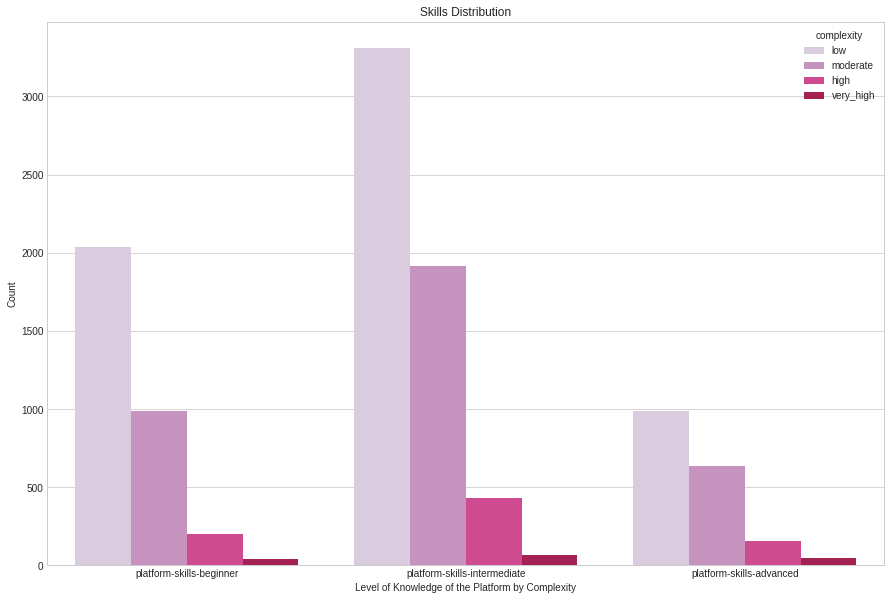

In [ ]:
sns.countplot(x="requester_platform_skills", hue='complexity', data=dataset, palette='PuRd',
              order=['platform-skills-beginner','platform-skills-intermediate','platform-skills-advanced'],
              hue_order=['low','moderate','high','very_high'])
plt.title('Skills Distribution')
plt.xlabel('Level of Knowledge of the Platform by Complexity')
plt.ylabel('Count')
# plt.savefig('Distribuicao-plataform-skills-by-complexity.png')
plt.show()

Outra suposição facilmente criada seria a de que usuários com maior domínio da plataforma seriam capazes de abrir chamados de maior complexidade, mas a classe de saída "very_high" é quase que igualmente distribuída entre todos os níveis de conhecimento.<br>

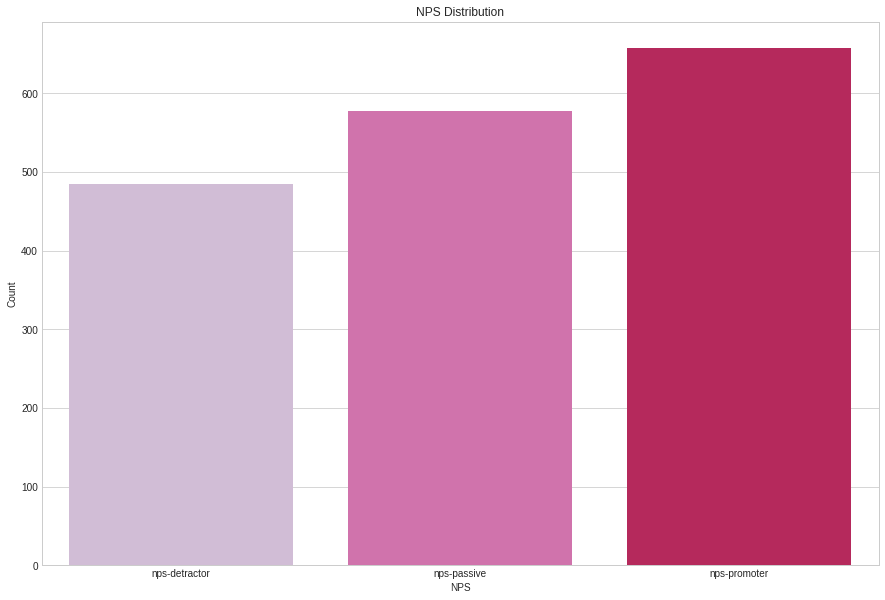

In [ ]:
sns.countplot(x="requester_nps", data=dataset, palette='PuRd', order=['nps-detractor','nps-passive','nps-promoter'])
plt.title('NPS Distribution')
plt.xlabel('NPS')
plt.ylabel('Count')
# plt.savefig('Distribuicao-NPS.png')
plt.show()

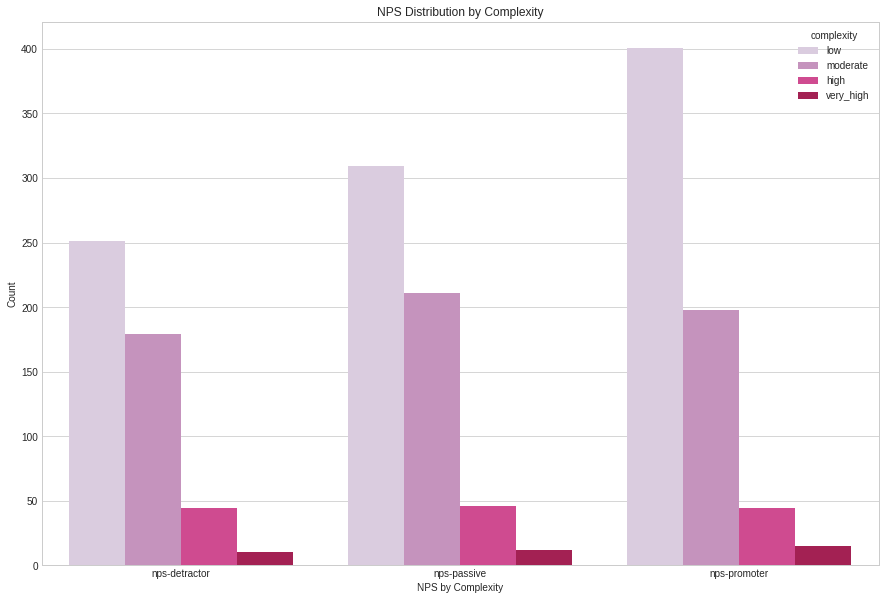

In [ ]:
sns.countplot(x="requester_nps", hue='complexity', data=dataset, palette='PuRd',
              order=['nps-detractor','nps-passive','nps-promoter'],
              hue_order=['low','moderate','high','very_high'])
plt.title('NPS Distribution by Complexity')
plt.xlabel('NPS by Complexity')
plt.ylabel('Count')
# plt.savefig('Distribuicao-NPS-by-complexity.png')
plt.show()

A distribuição de tickets de baixa e alta complexidade mostra-se equivalente, tanto para cliente detratores, quanto para clientes passivos e promotores da marca.

**Conclusão**
<br>
<br>
Através da análise exploratória dos dados não foi possível identificar padrões comportamentais que indicassem aplicabilidade na predição das classes de saída de forma mais ampla, sendo principalmente ineficaz em determinar padrões nas classes de saída minoritárias.

# Pré-Processamento

## Tratamento de datas

Com o propósito de agregar valor à base inicial de dados através de variáveis existentes envolvendo datas de criação dos tickets ou data de registro do usuário na plataforma de atendimento, utilizou-se a biblioteca Datetime para converter os dias originais em informações de dias da semana e tempo de duração do usuário.
<br>
<br>
Para a variável "created_at" optou-se pela interpretação de dias da semana para compreender o comportamento de abertura de tickets ao longo da semana, onde:


*   0 - Segunda-feira
*   1 - Terça-feira
*   2 - Quarta-feira
*   3 - Quinta-feira
*   4 - Sexta-feira
*   5 - Sábado
*   6 - Domingo



In [ ]:
from datetime import datetime

weekday = []

for i in dataset['created_at']:
  weekday.append((datetime.strptime(i, '%Y-%m-%dT%H:%M:%S.000Z').date()).weekday())

dataset['weekday'] = weekday
dataset.head()

,created_at,type,priority,status,is_public,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating,weekday
id,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,incident,high,hold,True,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None,2
166035,2019-06-12T15:23:14.000Z,incident,high,open,True,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None,2
182449,2019-08-23T21:13:47.000Z,question,normal,hold,True,144968,379450971772,3.600155e+11,2.559354e+08,False,False,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None,4
189041,2019-09-20T16:33:59.000Z,incident,normal,solved,True,144968,378569033032,3.600120e+11,1.403345e+08,True,False,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None,4
210457,2019-12-19T03:08:31.000Z,incident,normal,closed,True,144968,367417544031,3.600120e+11,1.151715e+11,True,False,367417544031,2018-07-24T15:17:28.000Z,None,platform-skills-intermediate,high,None,3


Utilizando a informação de horário de abertura do ticket, criou-se uma variável para determinar se o ticket foi criado dentro do horário comercial de atendimento do time de suporte, sendo:


*   0 para tickets criados fora do horário comercial
*   1 para tickets criados dentro do horário comercial
<br>
<br>
OBS: Tickets criados aos sábados ou domingos, independente do horário, são considerados fora do horário comercial.


In [ ]:
variavel = []

for i in dataset['created_at']:
  variavel.append(datetime.strptime(i, '%Y-%m-%dT%H:%M:%S.000Z'))

business_hours = []
horaInicial = (datetime.strptime('09:00:00', '%H:%M:%S').time())
horaFinal = (datetime.strptime('18:00:00', '%H:%M:%S').time())

for i in variavel:
  if i.weekday() == 5 or i.weekday() == 6:
    business_hours.append(0)
  else:
    if i.time() >= horaInicial and i.time() <= horaFinal:
      business_hours.append(1)
    else:
      business_hours.append(0)

In [ ]:
dataset['is_business_hours'] = business_hours
dataset.head()

,created_at,type,priority,status,is_public,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating,weekday,is_business_hours
id,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,incident,high,hold,True,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None,2,1
166035,2019-06-12T15:23:14.000Z,incident,high,open,True,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None,2,1
182449,2019-08-23T21:13:47.000Z,question,normal,hold,True,144968,379450971772,3.600155e+11,2.559354e+08,False,False,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None,4,0
189041,2019-09-20T16:33:59.000Z,incident,normal,solved,True,144968,378569033032,3.600120e+11,1.403345e+08,True,False,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None,4,1
210457,2019-12-19T03:08:31.000Z,incident,normal,closed,True,144968,367417544031,3.600120e+11,1.151715e+11,True,False,367417544031,2018-07-24T15:17:28.000Z,None,platform-skills-intermediate,high,None,3,0


In [ ]:
# Calculando tempo de duração do requester com base na data de criação menos data de abertura do ticket

creationUser = []
for i in dataset['requester_created_at']:
    creationUser.append(datetime.strptime(i, '%Y-%m-%dT%H:%M:%S.000Z').date())

creationTicket = []
for i in dataset['created_at']:
    creationTicket.append(datetime.strptime(i, '%Y-%m-%dT%H:%M:%S.000Z').date())
    
duration_days = []
for i in range(len(creationUser)):
    duration_days.append((creationTicket[i]-creationUser[i]).days)

# Incluindo nova coluna ao DataFrame com dados de duração dos tickets
dataset['requester_duration_days'] = duration_days
dataset.head()

,created_at,type,priority,status,is_public,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating,weekday,is_business_hours,requester_duration_days
id,,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,incident,high,hold,True,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None,2,1,1029
166035,2019-06-12T15:23:14.000Z,incident,high,open,True,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None,2,1,1043
182449,2019-08-23T21:13:47.000Z,question,normal,hold,True,144968,379450971772,3.600155e+11,2.559354e+08,False,False,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None,4,0,141
189041,2019-09-20T16:33:59.000Z,incident,normal,solved,True,144968,378569033032,3.600120e+11,1.403345e+08,True,False,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None,4,1,186
210457,2019-12-19T03:08:31.000Z,incident,normal,closed,True,144968,367417544031,3.600120e+11,1.151715e+11,True,False,367417544031,2018-07-24T15:17:28.000Z,None,platform-skills-intermediate,high,None,3,0,513


## One Hot Encoding

Transformando variáveis categóricas em valores numéricos para posterior aplicação de algoritmos de predição.

In [ ]:
# Variáveis 'type', 'priority', 'requester_nps' e 'requester_platform_skills'

types = pd.get_dummies(dataset['type'], prefix = 'type', drop_first = False)
prioritys = pd.get_dummies(dataset.priority, prefix = 'priority', drop_first = False)
nps = pd.get_dummies(dataset.requester_nps, prefix = 'requester', drop_first = False)
skills = pd.get_dummies(dataset.requester_platform_skills, prefix = 'requester', drop_first = False)

frames = [dataset, types, prioritys, nps, skills]
dataset = pd.concat(frames,axis=1)
dataset = dataset.drop(['type', 'priority','requester_nps','requester_platform_skills'], axis=1)
dataset.head()

,created_at,status,is_public,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,complexity,is_operating,weekday,is_business_hours,requester_duration_days,type_incident,type_problem,type_question,type_task,priority_high,priority_low,priority_normal,priority_urgent,requester_nps-detractor,requester_nps-passive,requester_nps-promoter,requester_platform-skills-advanced,requester_platform-skills-beginner,requester_platform-skills-intermediate
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,hold,True,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,high,None,2,1,1029,1,0,0,0,1,0,0,0,1,0,0,1,0,0
166035,2019-06-12T15:23:14.000Z,open,True,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,very_high,None,2,1,1043,1,0,0,0,1,0,0,0,1,0,0,1,0,0
182449,2019-08-23T21:13:47.000Z,hold,True,144968,379450971772,3.600155e+11,2.559354e+08,False,False,379450971772,2019-04-04T13:34:21.000Z,very_high,None,4,0,141,0,0,1,0,0,0,1,0,0,0,0,1,0,0
189041,2019-09-20T16:33:59.000Z,solved,True,144968,378569033032,3.600120e+11,1.403345e+08,True,False,378569033032,2019-03-18T20:21:53.000Z,moderate,None,4,1,186,1,0,0,0,0,0,1,0,0,0,0,0,0,1
210457,2019-12-19T03:08:31.000Z,closed,True,144968,367417544031,3.600120e+11,1.151715e+11,True,False,367417544031,2018-07-24T15:17:28.000Z,high,None,3,0,513,1,0,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
# Alterando valores booleanos para numéricos

dataset['has_partner'] = dataset['has_partner'].replace({True: 1, False: 0})
dataset['has_success_manager'] = dataset['has_success_manager'].replace({True: 1, False: 0})
dataset['is_operating'] = dataset['is_operating'].replace({'sf-account-isoperating-true': 1, 'sf-account-isoperating-false': 0})

Dentro da plataforma do Zendesk, a abertura dos chamados pode ser feita por ação do cliente (em nossa base de dados identificado como "requester_id") ou do próprio agente de suporte da VTEX.
<br>
Para esse último caso, o agente abre o chamado em nome do cliente, a variável de "requester_id" segue referênciando o cliente envolvido no chamado, mas a variável "submitter_id" passa a carregar o id do agente que criou o ticket.
<br>
<br>
Para indicar essa ocorrência, criou-se uma nova variável intitulada "requester_equal_submitter" para identificar se o id do cliente era o mesmo de quem submeteu o chamado.
<br>
<br>
Para esta nova variável:


*   0 representa os chamados em que requester e submitter são iguais
*   1 representa os chamados em que requester e submitter são diferentes, indicando a abertura do chamado por parte de um agente e não pelo próprio cliente




In [ ]:
data = []

for i in dataset.index:
  if dataset.loc[i,'requester_id'] == dataset.loc[i,'submitter_id']:
    data.append(0)
  else:
    data.append(1)

dataset['requester_equal_submitter'] = data
dataset.head()

,created_at,status,is_public,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,complexity,is_operating,weekday,is_business_hours,requester_duration_days,type_incident,type_problem,type_question,type_task,priority_high,priority_low,priority_normal,priority_urgent,requester_nps-detractor,requester_nps-passive,requester_nps-promoter,requester_platform-skills-advanced,requester_platform-skills-beginner,requester_platform-skills-intermediate,requester_equal_submitter
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,hold,True,144968,8958433768,3.600088e+11,3.601459e+11,0.0,0.0,8958433768,2016-08-03T15:18:13.000Z,high,NaN,2,1,1029,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0
166035,2019-06-12T15:23:14.000Z,open,True,144968,8958433768,3.600139e+11,3.601459e+11,0.0,0.0,8958433768,2016-08-03T15:18:13.000Z,very_high,NaN,2,1,1043,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0
182449,2019-08-23T21:13:47.000Z,hold,True,144968,379450971772,3.600155e+11,2.559354e+08,0.0,0.0,379450971772,2019-04-04T13:34:21.000Z,very_high,NaN,4,0,141,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
189041,2019-09-20T16:33:59.000Z,solved,True,144968,378569033032,3.600120e+11,1.403345e+08,1.0,0.0,378569033032,2019-03-18T20:21:53.000Z,moderate,NaN,4,1,186,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
210457,2019-12-19T03:08:31.000Z,closed,True,144968,367417544031,3.600120e+11,1.151715e+11,1.0,0.0,367417544031,2018-07-24T15:17:28.000Z,high,NaN,3,0,513,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


## Exclusão de variáveis

As variáveis "created_at", "requester_created_at" e "submitter_id" serão excluídas em função de já terem sido tratadas nas etapas anteriores e agora apresentam redundância de informação.
<br>
<br>
A variável "status" é uma variável que indica as etapas de atendimento, desde a abertura, posterior tratativa e conclusão.
<br>
Por se tratar de uma análise que capta informações presentes no ticket apenas na abertura do chamado, antes de se iniciar sua tratativa, essa variável se mostrou irrelevante para o desenvolvimento do modelo.

In [ ]:
dataset = dataset.drop(['created_at', 'requester_created_at' ,'status', 'submitter_id'], axis=1)
dataset.head()

,is_public,brand_id,group_id,organization_id,has_partner,has_success_manager,requester_id,complexity,is_operating,weekday,is_business_hours,requester_duration_days,type_incident,type_problem,type_question,type_task,priority_high,priority_low,priority_normal,priority_urgent,requester_nps-detractor,requester_nps-passive,requester_nps-promoter,requester_platform-skills-advanced,requester_platform-skills-beginner,requester_platform-skills-intermediate,requester_equal_submitter
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
162875,True,144968,3.600088e+11,3.601459e+11,0.0,0.0,8958433768,high,NaN,2,1,1029,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0
166035,True,144968,3.600139e+11,3.601459e+11,0.0,0.0,8958433768,very_high,NaN,2,1,1043,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0
182449,True,144968,3.600155e+11,2.559354e+08,0.0,0.0,379450971772,very_high,NaN,4,0,141,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
189041,True,144968,3.600120e+11,1.403345e+08,1.0,0.0,378569033032,moderate,NaN,4,1,186,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
210457,True,144968,3.600120e+11,1.151715e+11,1.0,0.0,367417544031,high,NaN,3,0,513,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
# Claculando a variância dos dados

from statistics import pvariance

X = dataset.drop('complexity', axis=1)

for i in range(len(X.columns)):
  print(f'{X.columns[i]}: {pvariance(X.iloc[:, i])}')

is_public: 0.15476014157031567
brand_id: 0
group_id: 2.5610041098585847e+20
organization_id: nan
has_partner: nan
has_success_manager: nan
requester_id: 8.842008933408583e+21
is_operating: nan
weekday: 2.161339206708857
is_business_hours: 0.24757900417116896
requester_duration_days: 192126.90762950887
type_incident: 0.10370939207005354
type_problem: 0.007009995128169539
type_question: 0.1589638882284605
type_task: 0.0659837456166961
priority_high: 0.1948164687512566
priority_low: 0.24494878648058707
priority_normal: 0.17837521767112421
priority_urgent: 0.0681930252955296
requester_nps-detractor: 0.039933843915002216
requester_nps-passive: 0.04728685741732944
requester_nps-promoter: 0.05344155999384026
requester_platform-skills-advanced: 0.1325543790973456
requester_platform-skills-beginner: 0.2018950290095359
requester_platform-skills-intermediate: 0.24995076467724636
requester_equal_submitter: 0.16261524454865522


Identificou-se que a variável "brand_id" possui nenhuma variância nos dados paresentando valor igual a zero e, portanto, será removida da base por não agregar ao modelo.

In [ ]:
dataset = dataset.drop('brand_id', axis=1)
dataset.head()

,is_public,group_id,organization_id,has_partner,has_success_manager,requester_id,complexity,is_operating,weekday,is_business_hours,requester_duration_days,type_incident,type_problem,type_question,type_task,priority_high,priority_low,priority_normal,priority_urgent,requester_nps-detractor,requester_nps-passive,requester_nps-promoter,requester_platform-skills-advanced,requester_platform-skills-beginner,requester_platform-skills-intermediate,requester_equal_submitter
id,,,,,,,,,,,,,,,,,,,,,,,,,,
162875,True,3.600088e+11,3.601459e+11,0.0,0.0,8958433768,high,NaN,2,1,1029,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0
166035,True,3.600139e+11,3.601459e+11,0.0,0.0,8958433768,very_high,NaN,2,1,1043,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0
182449,True,3.600155e+11,2.559354e+08,0.0,0.0,379450971772,very_high,NaN,4,0,141,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
189041,True,3.600120e+11,1.403345e+08,1.0,0.0,378569033032,moderate,NaN,4,1,186,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
210457,True,3.600120e+11,1.151715e+11,1.0,0.0,367417544031,high,NaN,3,0,513,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


A variável "is_public" faz a distinção entre dois tipos de chamados presentes dentro da plataforma do Zendesk:


*   Tickets públicos ("is_public = True")
*   Chamados internos ("is_public = False")
<br>
<br>
Considerando que todos os chamados abertos por clientes são públicos (chamados internos são abertos pelos agentes para o time de Produto visando a análise de problemas mais complexos), as entradas da base de dados que contiverem o valor "is_public = True" serão mantidos e a variável será posteriormente descartada em função da zero variância. 


In [ ]:
# Manter apenas chamados públicos

unique, counts = np.unique(dataset['is_public'], return_counts=True)

for i in range(len(unique)):
  print(f'Total de {unique[i]}: {counts[i]}')

Total de False: 2223
Total de True: 9392


In [ ]:
# Descartando valores "False"

dataset = dataset[dataset['is_public'] == True]
dataset = dataset.drop(['is_public'], axis=1)
dataset.head()

,group_id,organization_id,has_partner,has_success_manager,requester_id,complexity,is_operating,weekday,is_business_hours,requester_duration_days,type_incident,type_problem,type_question,type_task,priority_high,priority_low,priority_normal,priority_urgent,requester_nps-detractor,requester_nps-passive,requester_nps-promoter,requester_platform-skills-advanced,requester_platform-skills-beginner,requester_platform-skills-intermediate,requester_equal_submitter
id,,,,,,,,,,,,,,,,,,,,,,,,,
162875,3.600088e+11,3.601459e+11,0.0,0.0,8958433768,high,NaN,2,1,1029,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0
166035,3.600139e+11,3.601459e+11,0.0,0.0,8958433768,very_high,NaN,2,1,1043,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0
182449,3.600155e+11,2.559354e+08,0.0,0.0,379450971772,very_high,NaN,4,0,141,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
189041,3.600120e+11,1.403345e+08,1.0,0.0,378569033032,moderate,NaN,4,1,186,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
210457,3.600120e+11,1.151715e+11,1.0,0.0,367417544031,high,NaN,3,0,513,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


## Análise Exploratória das novas variáveis

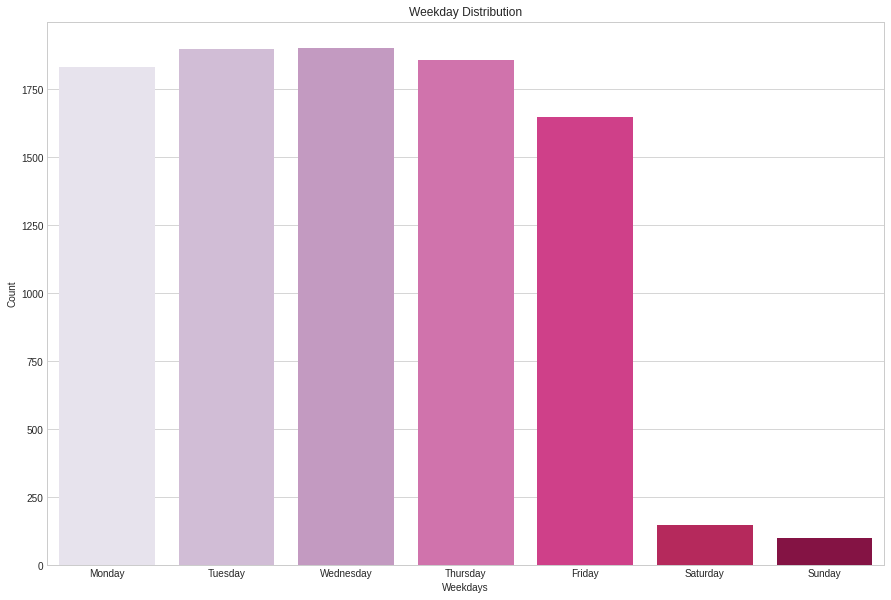

In [ ]:
sns.countplot(x="weekday", data=dataset, palette='PuRd')
plt.title('Weekday Distribution')
plt.xlabel('Weekdays')
plt.ylabel('Count')
plt.xticks([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
# plt.savefig('Distribuicao-dias-da-semana.png')
plt.show()

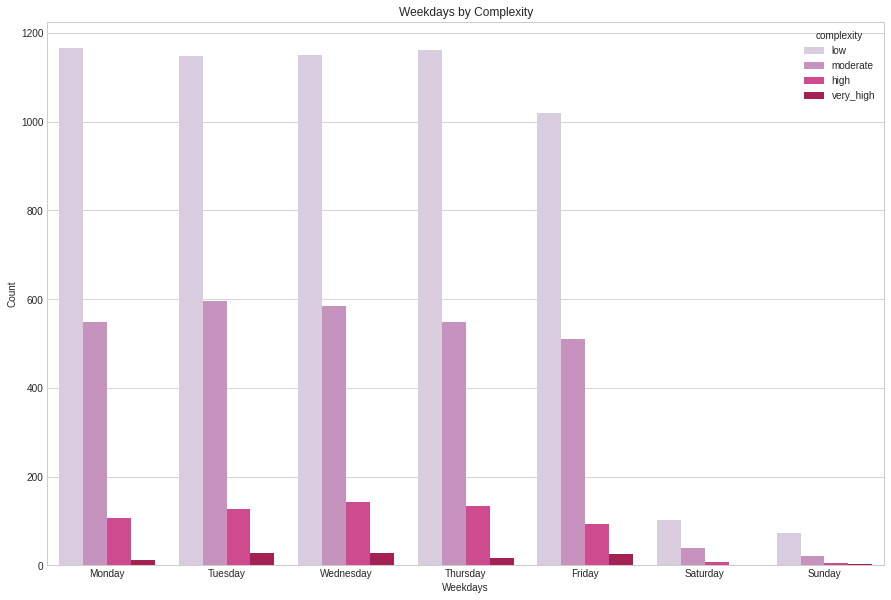

In [ ]:
sns.countplot(x="weekday", data=dataset, hue='complexity', palette='PuRd',hue_order=['low','moderate','high','very_high'])
plt.title('Weekdays by Complexity')
plt.xlabel('Weekdays')
plt.ylabel('Count')
plt.xticks([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
# plt.savefig('Dias-da-semana-por-complexidade.png')
plt.show()

Optou-se pela separação dos tickets entre os dias da semana para compreender essa distribuição e tentar entender se, durante os finais de semana existia maior probabilidade de abertura de tickets de alta complexidade.

In [ ]:
quartas = dataset[dataset['weekday'] == 2]
sabados = dataset[dataset['weekday'] == 5]
domingos = dataset[dataset['weekday'] == 6]

print('Propoção de abertura de tickets de alta complexidade aos finais de semana')
print(f"Proporção de tickets High às Quartas: {len(quartas[quartas['complexity'] == 'high']) / len(quartas)*100}")
print(f"Proporção de tickets Very High às Quartas: {len(quartas[quartas['complexity'] == 'very_high']) / len(quartas)*100}")
print(f"Proporção de tickets High aos Sábados: {len(sabados[sabados['complexity'] == 'high']) / len(sabados)*100}")
print(f"Proporção de tickets Very High aos Sábados: {len(sabados[sabados['complexity'] == 'very_high']) / len(sabados)*100}")
print(f"Proporção de tickets High aos Domingos: {len(domingos[domingos['complexity'] == 'high']) / len(domingos)*100}")
print(f"Proporção de tickets Very High aos Domingos: {len(domingos[domingos['complexity'] == 'Very_high']) / len(domingos)*100}")

Propoção de abertura de tickets de alta complexidade aos finais de semana
Proporção de tickets High às Quartas: 7.510504201680672
Proporção de tickets Very High às Quartas: 1.4180672268907564
Proporção de tickets High aos Sábados: 5.333333333333334
Proporção de tickets Very High aos Sábados: 0.6666666666666667
Proporção de tickets High aos Domingos: 5.0
Proporção de tickets Very High aos Domingos: 0.0


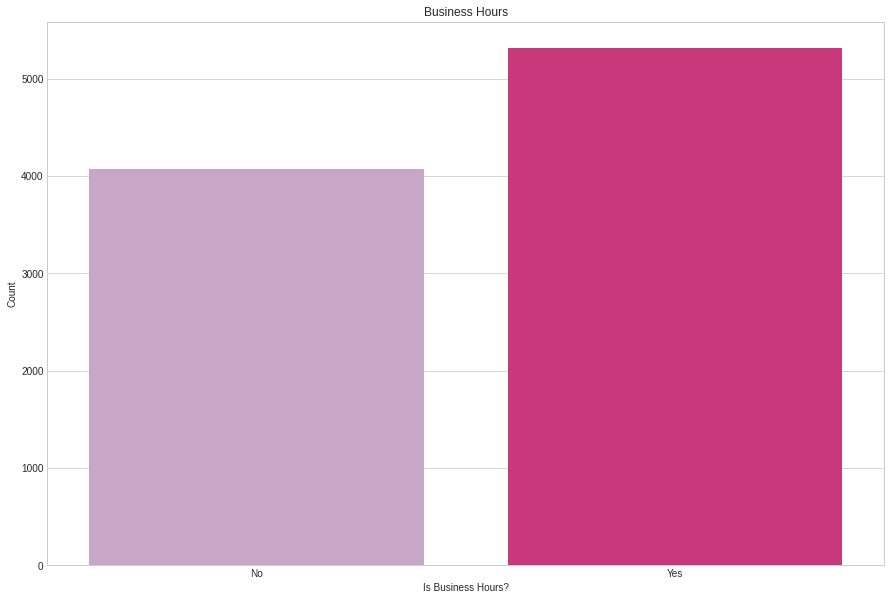

In [ ]:
sns.countplot(x="is_business_hours", data=dataset, palette='PuRd')
plt.title('Business Hours')
plt.ylabel('Count')
plt.xlabel('Is Business Hours?')
plt.xticks([0,1],['No','Yes'])
# plt.savefig('Distribuicao-horario-de-criacao.png')
plt.show()

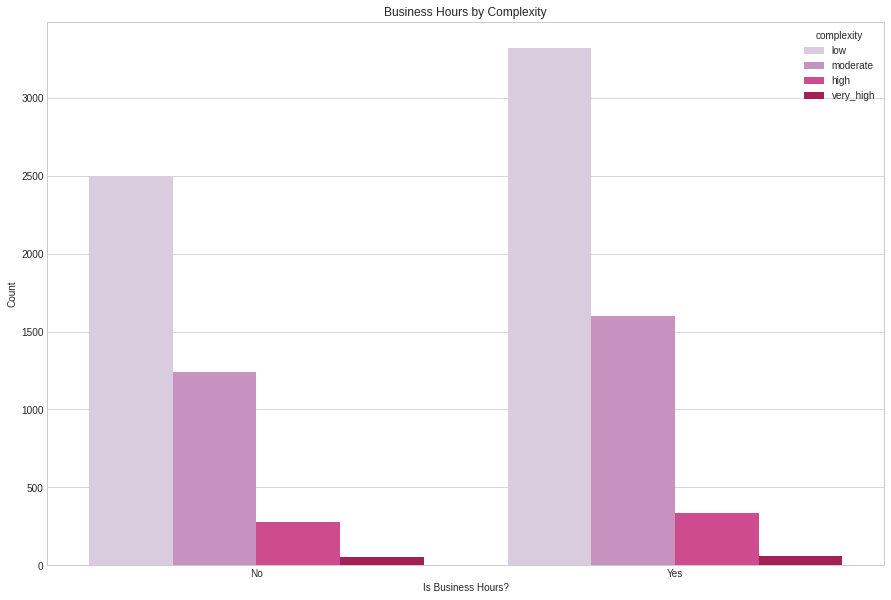

In [ ]:
sns.countplot(x="is_business_hours", data=dataset, hue='complexity', palette='PuRd',
              hue_order=['low','moderate','high','very_high'])
plt.title('Business Hours by Complexity')
plt.xlabel('Is Business Hours?')
plt.ylabel('Count')
plt.xticks([0,1],['No','Yes'])
# plt.savefig('Horario-comercial-por-complexidade.png')
plt.show()

O mesmo para chamados abertos fora do horário comercial. Aparentemente, ambos os comportamentos não influenciam no nível de complexidade para os tickets criados.

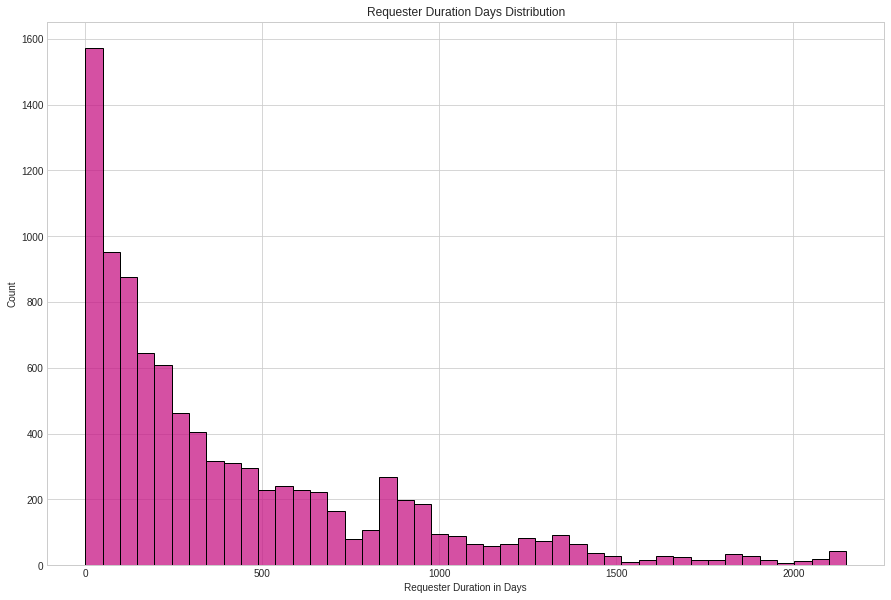

In [ ]:
sns.histplot(data=dataset, x='requester_duration_days',color='mediumvioletred')
plt.title('Requester Duration Days Distribution')
plt.ylabel('Count')
plt.xlabel('Requester Duration in Days')
# plt.savefig('Distribuicao-duracao-requester.png')
plt.show()

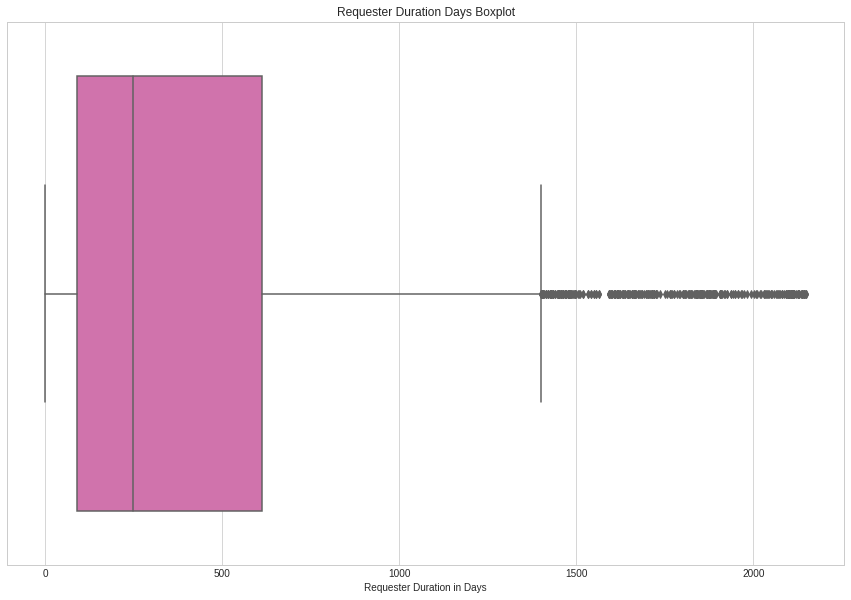

In [ ]:
sns.boxplot(x=dataset['requester_duration_days'], palette='PuRd')
plt.title('Requester Duration Days Boxplot')
plt.xlabel('Requester Duration in Days')
# plt.savefig('Boxplot-duracao-requester.png')
plt.show()

In [ ]:
Q1 = np.quantile(dataset['requester_duration_days'], q=0.25)
Q2 = np.quantile(dataset['requester_duration_days'], q=0.5)
Q3 = np.quantile(dataset['requester_duration_days'], q=0.75)
mean = np.mean(dataset['requester_duration_days'])
sd = np.std(dataset['requester_duration_days'])
limite_superior = mean + 2 * sd
limite_inferior = mean - 2 * sd

print(f'Q1: {Q1}')
print(f'Q2: {Q2}')
print(f'Q3: {Q3}')
print(f'Limite superior da distribuição: {limite_superior}')
print(f'Limite inferior da distribuição: {limite_inferior}')

Q1: 89.0
Q2: 248.0
Q3: 613.0
Limite superior da distribuição: 1289.0014066979693
Limite inferior da distribuição: -464.1376928989913


In [ ]:
new_values = []

for i in dataset.index:
  if (dataset['requester_duration_days'][i] < Q1):
    new_values.append(['Lower Values', dataset['complexity'][i]])
  elif ((dataset['requester_duration_days'][i] >= Q1) and (dataset['requester_duration_days'][i] < Q2)):
    new_values.append(['Q1', dataset['complexity'][i]])
  elif ((dataset['requester_duration_days'][i] >= Q2) and (dataset['requester_duration_days'][i] < Q3)):
    new_values.append(['Q3', dataset['complexity'][i]])
  elif ((dataset['requester_duration_days'][i] >= Q3) and (dataset['requester_duration_days'][i] < limite_superior)):
    new_values.append(['Higher Values', dataset['complexity'][i]])
  else:
    new_values.append(['Outliers', dataset['complexity'][i]])

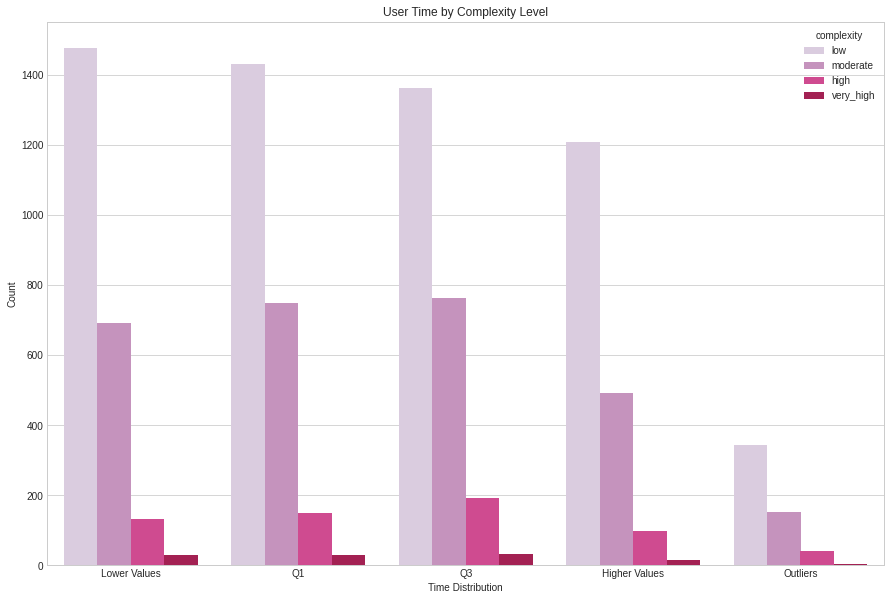

In [ ]:
df_new_values = pd.DataFrame(new_values, columns=['time classification', 'complexity'])

sns.countplot(x='time classification', data=df_new_values, hue='complexity', palette='PuRd',
              order=['Lower Values','Q1','Q3','Higher Values','Outliers'],
              hue_order=['low','moderate','high','very_high'])
plt.title('User Time by Complexity Level')
plt.xlabel('Time Distribution')
plt.ylabel('Count')
# plt.savefig('tempo-de-usuario-por-complexidade.png')
plt.show()

A variável "requester_duration_days" determina o tempo que o cliente tem cadastrado no sistema de suporte do Zendesk, e esse dado isso impacta diretamente na experiência do mesmo no manuseio da plataforma.<br>
Acreditava-se que, quanto maior fosse o tempo do usuário, maiores seriam suas dúvidas e, consequentemente a complexidade de seus questionamentos.<br><br>
Os usuários foram divididos conforme a disperção do dado em cinco grupos:


*   Amplitude mínima
*   Primeiro Quartil
*   Terceiro Quartil
*   Amplitude Máxima
*   Outliers

Observou-se uma diminuição na abertura de tickets de complexidade "low" conforme o usuário tinha mais tempo de contato com a plataforma, assim como um aumento gradual dos tickets de complexidade "moderate".<br>
E, apesar dos usuários em Q3 possuírem a maior taxa de abertura de tickets de complexidade "high", não existe um padrão visível para a abertura de tickets de complexidade "very_high".

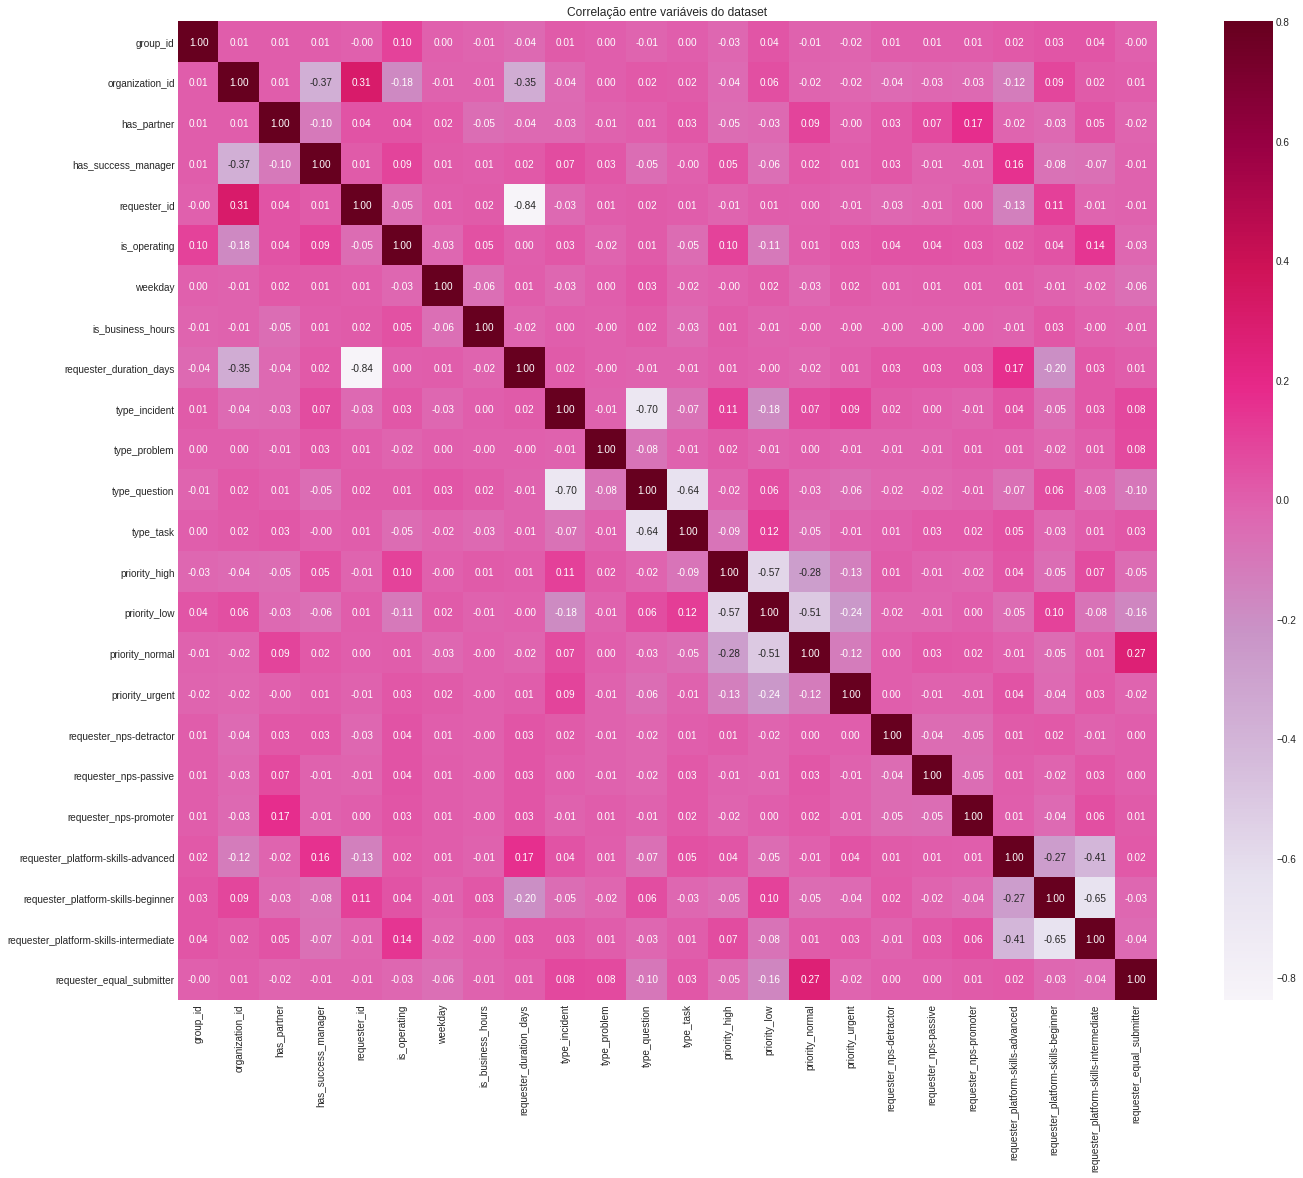

In [ ]:
# Matriz de correlação

correlation_matrix = dataset.corr()
fig = plt.figure(figsize=(24,18))
sns.heatmap(correlation_matrix,
            annot = True,
            fmt = '.2f',
            cmap='PuRd',
            vmax=0.8,
            square = True)
plt.title('Correlação entre variáveis do dataset')
# plt.savefig('Matriz-de-correlacao.png')
plt.show()

**Conclusões**
<br>
<br>
A maioria dos tickets são abertos durante os dias úteis, com uma pequena predominância de abertura às terças e quartas, porém não existe uma correlação entre níveis de complexidade e o dia da semana em que o ticket foi aberto.
<br>
<br>
Tampouco existe um padrão entre ticket abertos dentrou ou fora do horário comercial que possa determinar sua classe de saída.
<br>
<br>
É possível perceber também que o tempo de experiência dos usuários com a plataforma não é capaz de determinar sobre as classes de saída, sendo ainda menos representativo nas classes minoritárias.
<br>
<br>
Ao plotar a Matriz de Correlação entre as variáveis, percebe-se que existe pouca correlação entre as variáveis do modelo de forma geral.

# Tratando Missing Values

In [ ]:
# Analisando somatório de valores nulls na base de dados

dataset.isnull().sum()

group_id                                    0
organization_id                           389
has_partner                               389
has_success_manager                       389
requester_id                                0
complexity                                  0
is_operating                              170
weekday                                     0
is_business_hours                           0
requester_duration_days                     0
type_incident                               0
type_problem                                0
type_question                               0
type_task                                   0
priority_high                               0
priority_low                                0
priority_normal                             0
priority_urgent                             0
requester_nps-detractor                     0
requester_nps-passive                       0
requester_nps-promoter                      0
requester_platform-skills-advanced

In [ ]:
# Separando Output do dataset para tratar missing values

X = dataset.drop('complexity', axis = 1)
y = dataset['complexity']

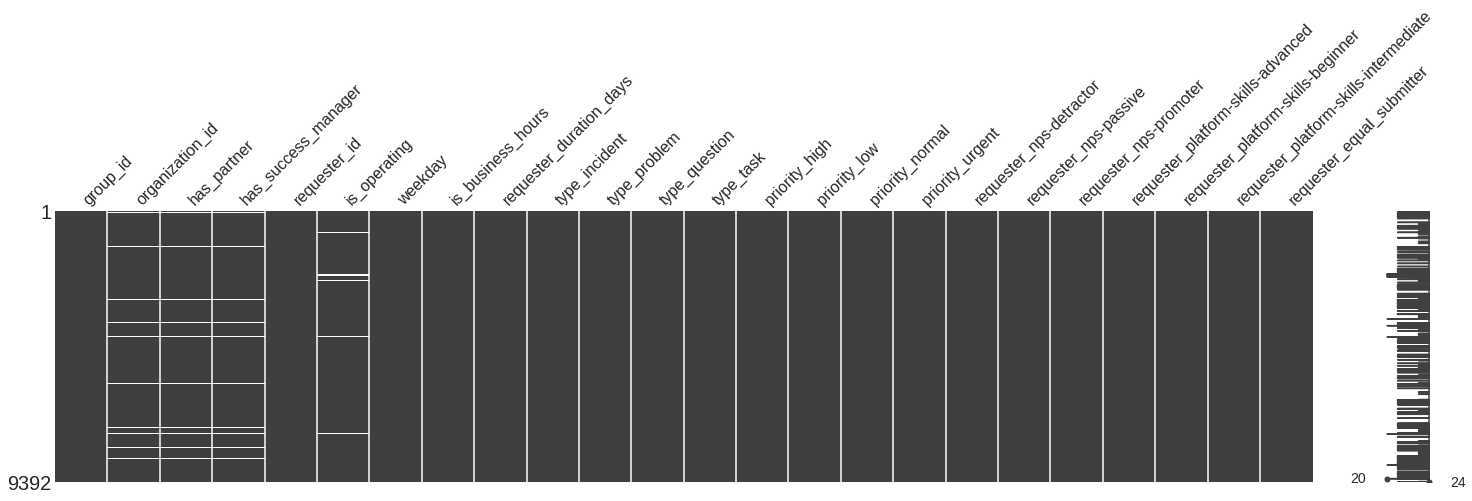

In [ ]:
# Visualizando missing

import missingno as msno

msno.matrix(X, figsize=(25,5));

In [ ]:
# Verificar missing por coluna

percent_missing = X.apply(lambda x: x.isnull().sum() * 100 / len(X), axis=0).sort_values(ascending=False)
df = pd.DataFrame({'percent_missing': percent_missing})
df.head()

,percent_missing
organization_id,4.141823
has_partner,4.141823
has_success_manager,4.141823
is_operating,1.810051
requester_equal_submitter,0.000000


Considerando que a base de dados possui, em sua maioria, variáveis do tipo categórica, optou-se pela utilização da moda para a substituição dos valores faltantes.

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(X)
X = imputer.transform(X)

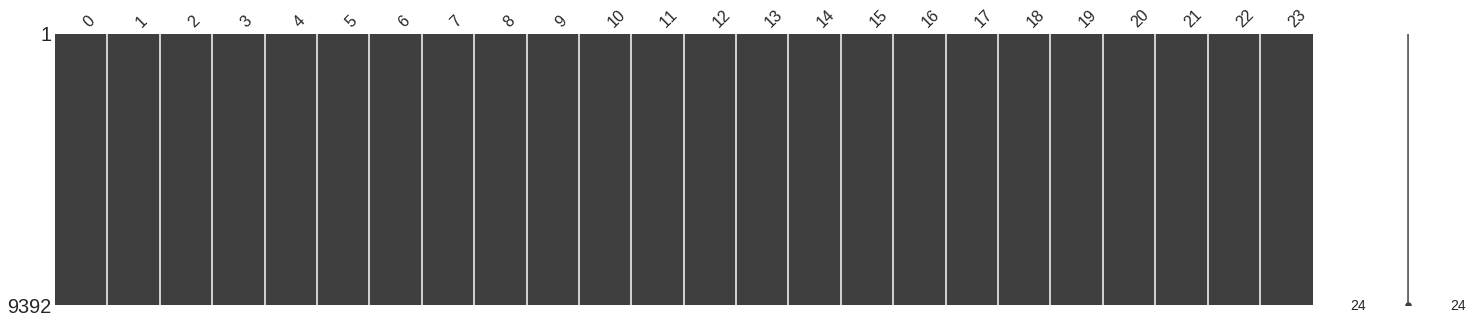

In [ ]:
msno.matrix(pd.DataFrame(X), figsize=(25,5));

# Aplicando PCA

Redução de dimensionalidade da base preservando o máximo possível da variação dos dados.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(X)
X_PCA = pca.transform(X)

In [ ]:
X_PCA = pd.DataFrame(X_PCA)
y = y.reset_index()
y = y.drop('id', axis = 1)

frames = [X_PCA, y]
df = pd.concat(frames,axis=1)
df.tail()

,0,1,complexity
9387,2.219492e+11,-8.802422e+10,low
9388,-1.305893e+11,-9.884713e+09,low
9389,2.179364e+11,-4.148014e+10,low
9390,2.218665e+11,-8.838712e+10,moderate
9391,-1.260028e+11,7.921994e+09,low


In [ ]:
print("Variância explicada:")
print(pca.explained_variance_ratio_)

Variância explicada:
[0.78033168 0.21099843]


A porcentagem da variância explicada para cada um dos componentes selecionados compreende aproximadamente 99% do total.

# Unindo classes majoritárias e minoritárias

Considerando que os modelos treinados tem como finalidade a minimização dos erros na predição das classes de saída, a classe com maior número de dados terá a maior probabilidade de classificação. Enquanto que, em contra partida, quanto maiores forem as amostras sintéticas geradas na tentativa de equalizar o modelo de menor predominância, maior se torna a probabilidade de over-fitting.
<br><br>
Em adição, com o cruzamento de dados realizado na Análise Exploratória, podemos afimar que existe similaridades entre as classes *"low"* e *"moderate"*, e *"high"* e *"very_high"* que justifica o uso de apenas dois outputs, *"easy"* e *"hard"* respectivamente.

In [ ]:
df['complexity'] = df['complexity'].replace({'low': 'easy', 'moderate': 'easy', 'high': 'hard', 'very_high': 'hard'})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


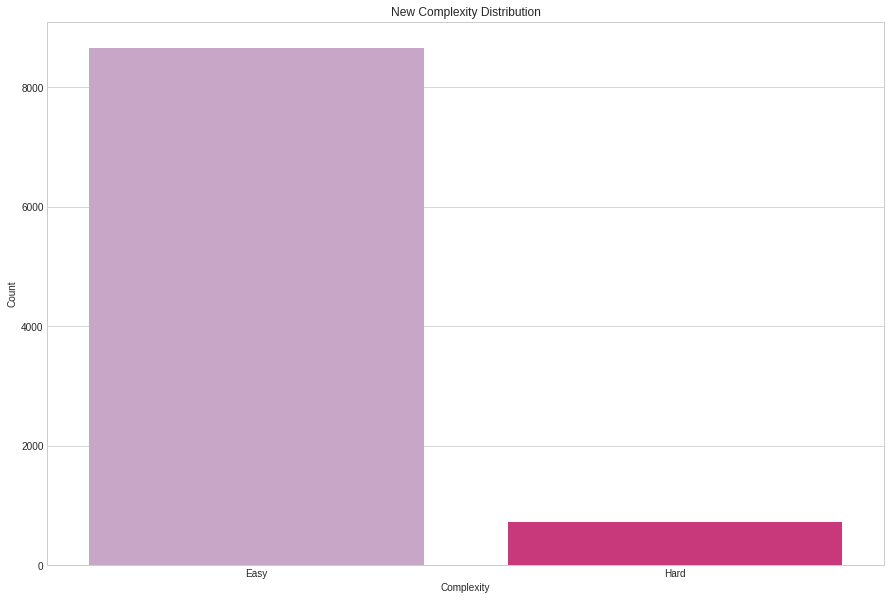

In [ ]:
sns.countplot(df['complexity'], palette='PuRd',order=['easy','hard'])
plt.title('New Complexity Distribution')
plt.xlabel('Complexity')
plt.ylabel('Count')
plt.xticks([0,1],['Easy','Hard'])
# plt.savefig('nova-distribuicao-complexity.png')
plt.show()

In [ ]:
unique, counts = np.unique(df['complexity'], return_counts=True)

for i in range(len(unique)):
  print(f'Total de {unique[i]}: {counts[i]}')

Total de easy: 8666
Total de hard: 726


# Separando base de treino e teste

In [ ]:
# semente para reprodução de resultados
seed=1000

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns != 'complexity'],
                                                    df['complexity'], test_size=0.2, stratify=df['complexity'],
                                                    random_state=seed)

print('Shape Input de Treino: ', X_train.shape)
print('Shape Input de Teste: ', X_test.shape)
print('Shape Output de Treino: ', y_train.shape)
print('Shape Output de Teste: ', y_test.shape)

Shape Input de Treino:  (7513, 2)
Shape Input de Teste:  (1879, 2)
Shape Output de Treino:  (7513,)
Shape Output de Teste:  (1879,)


# Random Oversampling and Undersampling for Imbalanced Classification

Com o intuito de mitigar os efeitos de over-sampling já mencionados anteriormente e, levando em consideração o desbalanceamento existente entre as classes, optou-se pela aplicação do método de combinação entre o under-sampling e o over-sampling denominado SMOTEENN.
<br>
O método utiliza as técnicas de SMOTE e Edited Nearest Neighbours (ENN) de forma simultânea.

In [ ]:
from imblearn.combine import SMOTEENN

sme = SMOTEENN(random_state=seed)
X_res, y_res = sme.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [ ]:
from collections import Counter
print('Original dataset shape %s' % Counter(y_res))

Original dataset shape Counter({'easy': 4607, 'hard': 4067})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


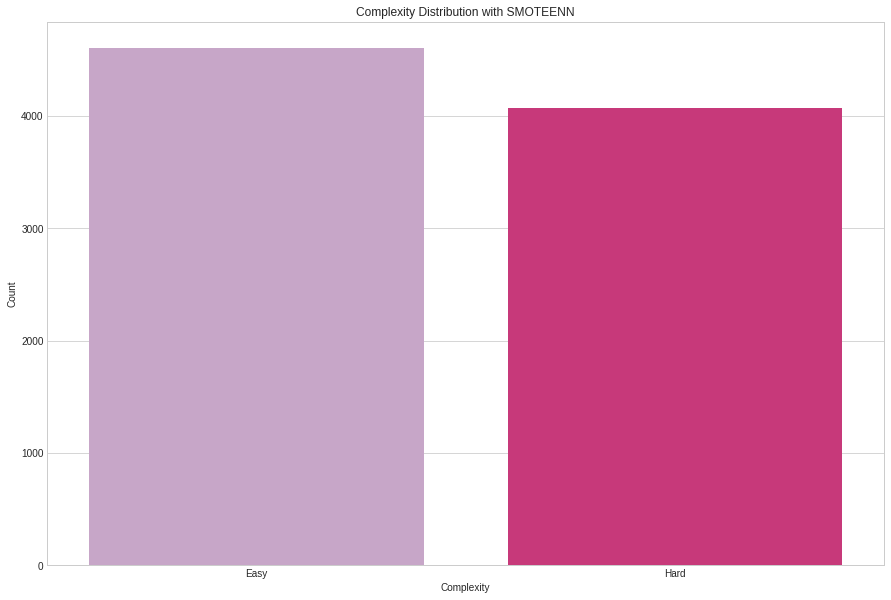

In [ ]:
sns.countplot(y_res, palette='PuRd', order=['easy','hard'])
plt.title('Complexity Distribution with SMOTEENN')
plt.xlabel('Complexity')
plt.ylabel('Count')
plt.xticks([0,1],['Easy','Hard'])
# plt.savefig('nova-complexity-com-smoteenn.png')
plt.show()

## Decision Tree

Método de aprendizado supervisionado utilizado para problemas de regressão e classificação.<br>
Tem por objetivo criar modelos capazes de aprender regras de decisão simples do tipo "if-then-else", retornando ao final a predição da classe de saída.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def trainDecisionTree(X_train, y_train, seed):
  model = DecisionTreeClassifier(min_samples_leaf=5, random_state=seed)
  model.fit(X_train, y_train);
  return model

model = trainDecisionTree(X_res, y_res, seed)

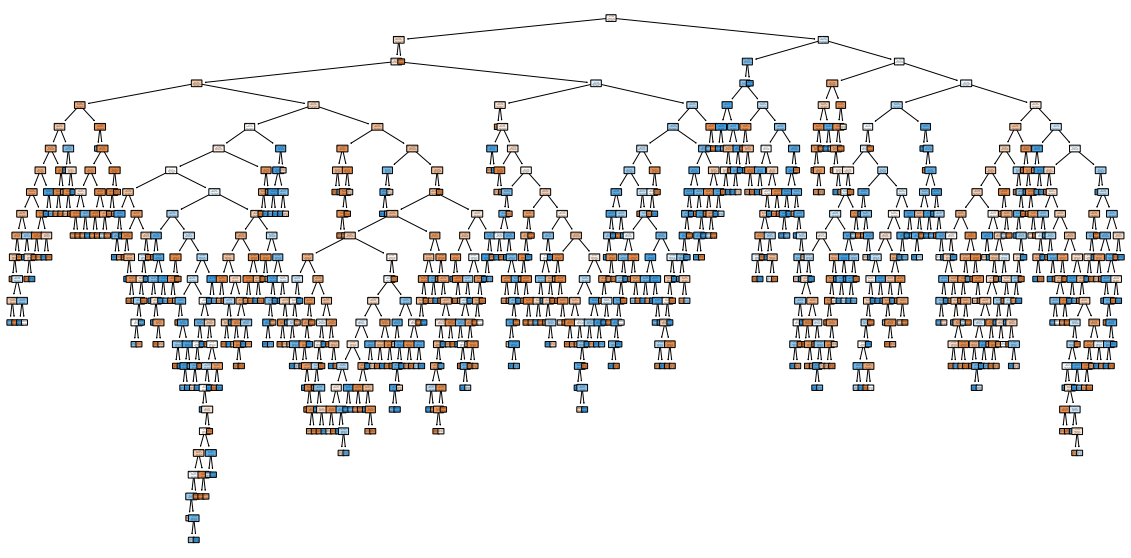

In [ ]:
# Visualização gráfica da árvore de decisão
from sklearn import tree
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(model, class_names=['Easy', 'Hard'], filled=True, rounded=True);

Acurácia:  0.7126130920702501
Kappa:  0.06979345245189261
F1:  0.7760069322230149


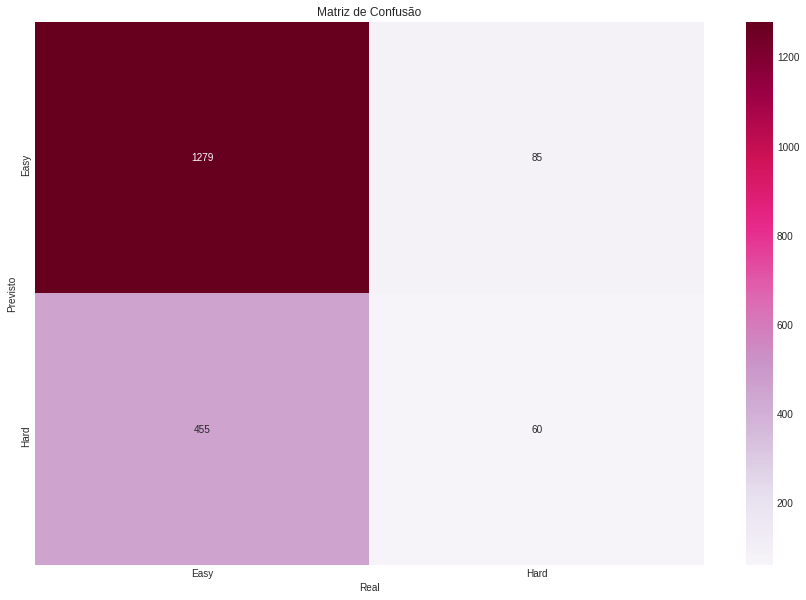

In [ ]:
def predict_and_evaluate(X_test, y_test, img_name):

  y_pred = model.predict(X_test) #inferência do teste

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred, average = 'weighted')
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred, y_test)

  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f",cmap='PuRd')
  plt.xlabel('Real')
  plt.ylabel('Previsto')
  plt.title('Matriz de Confusão')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['Easy', 'Hard']) 
  ax.yaxis.set_ticklabels(['Easy', 'Hard'])
  plt.savefig(img_name)
  plt.show()

predict_and_evaluate(X_test, y_test, 'smoteenn_decision_tree.jpg')

## Random Forest

Estimador que cria um conjunto de árvores de decisão para subamostras do conjunto de dados. O fator aleatoridade tende a produzir menos erros na predição das classes de saída e a acurácia do modelo é calculado em cima da média de sua previsão probabilística.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def trainRandomForest(X_train, y_train, seed):
  model = RandomForestClassifier(min_samples_leaf=5, random_state=seed)
  model.fit(X_train, y_train);
  return model

model = trainRandomForest(X_res, y_res, seed)

Acurácia:  0.7099521021820117
Kappa:  0.031554130284910165
F1:  0.7729318041849874


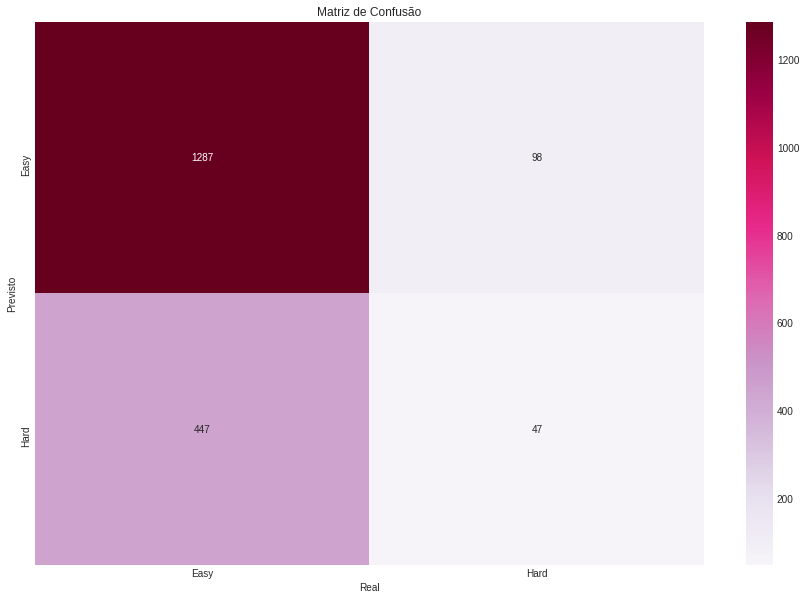

In [ ]:
predict_and_evaluate(X_test, y_test, 'smoteenn-random-forest.jpg')

## SVM

Support Vector Machines são um conjunto de métodos de aprendizado supervisionado usados ​​para classificação, regressão e detecção de outliers.

In [ ]:
from sklearn.svm import SVC

def trainSVM(X_train, y_train, seed):
  model = SVC(random_state=seed)
  model.fit(X_train, y_train)
  return model

model = trainSVM(X_res, y_res, seed)

Acurácia:  0.8648217136774881
Kappa:  -0.04122888159731919
F1:  0.8581397782796308


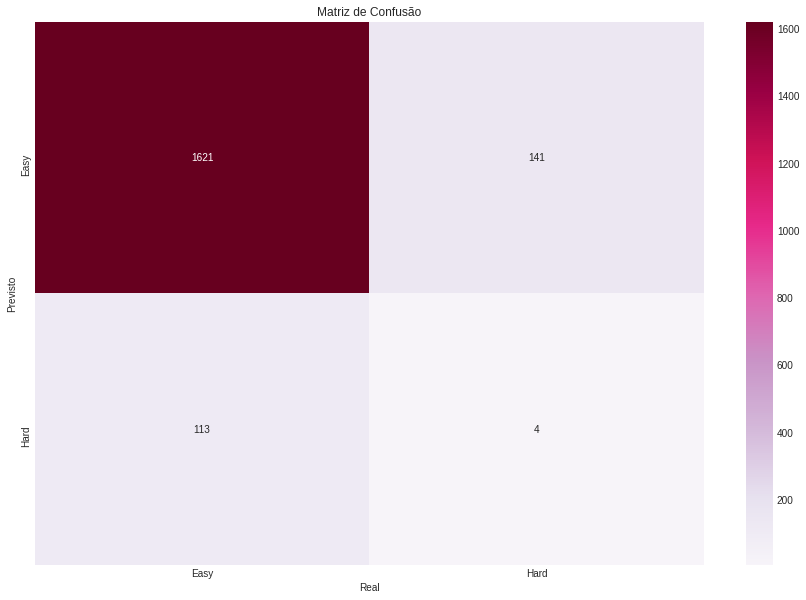

In [ ]:
predict_and_evaluate(X_test, y_test, 'smoteenn-svm.jpg')

## K Neighbors Classifier

Método de classificação não paramétrico baseado em instâncias ou aprendizagem não generalizante. A classificação é calculada a partir da avaliação da maioria dos vizinhos mais próximos.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def neigh(X_train, y_train, seed):
  model = KNeighborsClassifier(n_neighbors=2, weights='distance', leaf_size=10)
  model.fit(X_train, y_train);
  return model

model = neigh(X_res, y_res, seed)

Acurácia:  0.699308142629058
Kappa:  0.04754065268588081
F1:  0.766286051864039


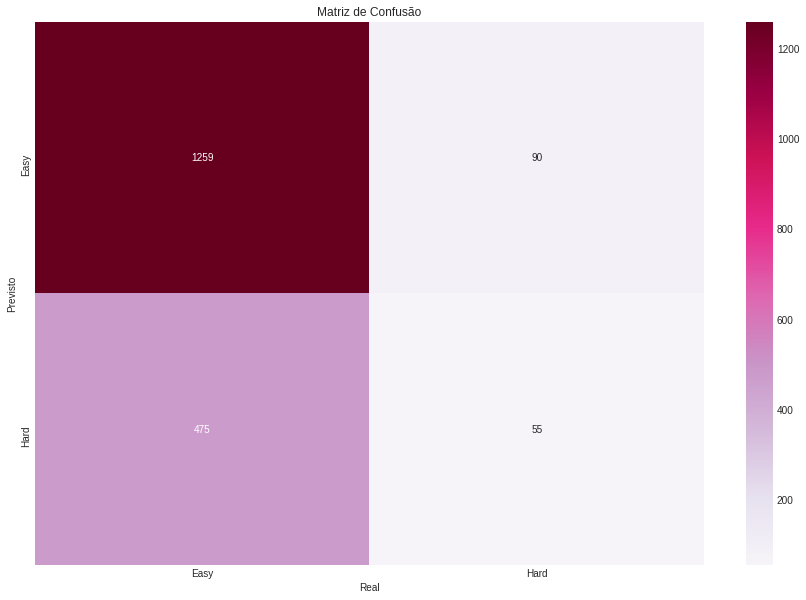

In [ ]:
predict_and_evaluate(X_test, y_test, 'smoteen-k-neighbors.jpg')

**Conclusão**
<br><br>
Foram utilizados quatro modelos preditivos para o problema de classificação, porém nenhum dos resultados obtidos foi satisfatório.<br>
Todos os modelos foram bem sucedidos na predição da classe "easy", o que eleva o valor da acurácia, mas ao analisarmos o desempenho dos modelos para a predição da classe "hard", identificamos uma considerável ineficiência preditiva.<br><br>
Para a melhor aferição dos resultados, foi utilizado o método f-score, que retorna o balanço entre a precisão e recall do modelo.<br>
Considerando essa métrica e o valor de Kappa, podemos afirmar que a Árvore de Decisão apresentou o melhor desempenho entre os quatro.

# Undersampling

Diante dos resultados anteriores, um novo teste foi realizado, dessa vez optando-se pela utilização do método de Under-sampling para o balanceamento da base de dados.<br>
Essa abordagem tem por fim compreender a classe minoritária como caso raro dentro do objetivo de classificação e evitar o over-fitting ao criar um número excessivo de amostram sintéticas para a base minoritária.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Original dataset shape %s' % Counter(y_rus))

Original dataset shape Counter({'easy': 581, 'hard': 581})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


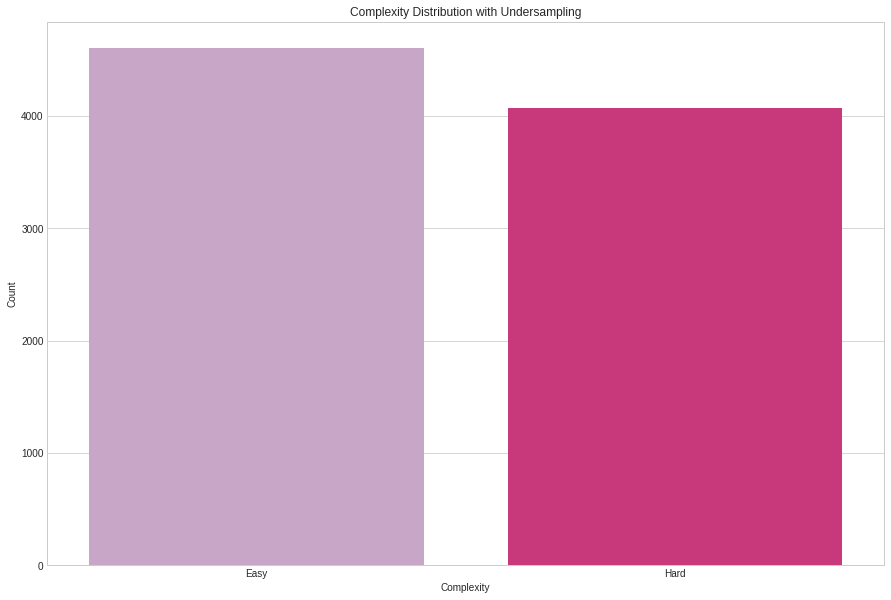

In [ ]:
sns.countplot(y_res, palette='PuRd', order=['easy','hard'])
plt.title('Complexity Distribution with Undersampling')
plt.xlabel('Complexity')
plt.ylabel('Count')
plt.xticks([0,1],['Easy','Hard'])
# plt.savefig('nova-complexity-com-undersampling.png')
plt.show()

## Decision Tree

In [ ]:
model = trainDecisionTree(X_rus, y_rus, seed)

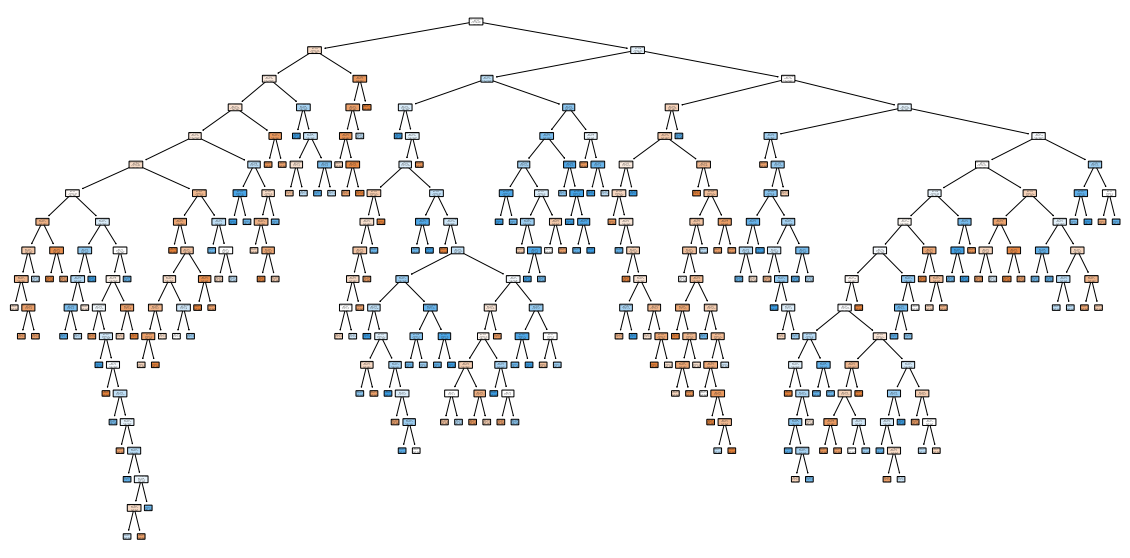

In [ ]:
# Visualização gráfica da árvore de decisão
from sklearn import tree
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(model, class_names=['Easy', 'Hard'], filled=True, rounded=True);

Acurácia:  0.5470995210218201
Kappa:  0.018676114371562136
F1:  0.6496209140509733


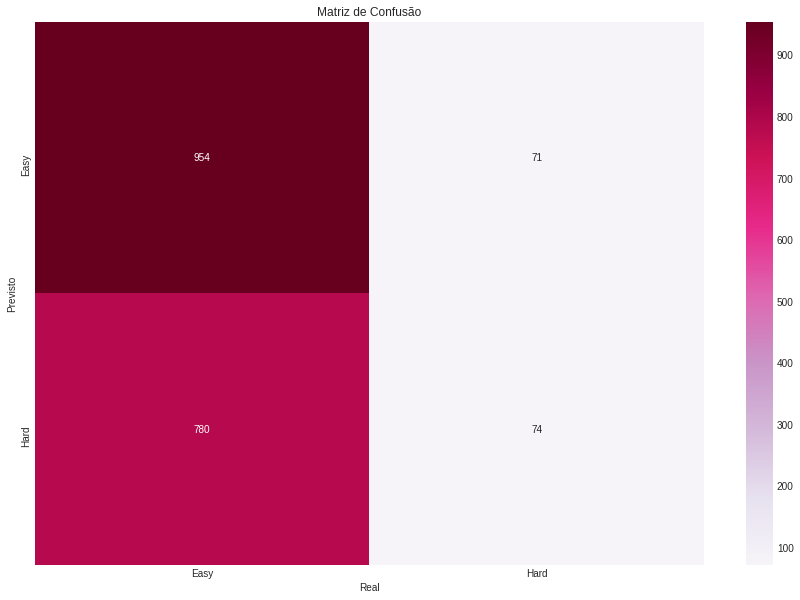

In [ ]:
predict_and_evaluate(X_test, y_test, 'under-decision-tree.jpg')

## Random Forest

In [ ]:
model = trainRandomForest(X_rus, y_rus, seed)

Acurácia:  0.5662586482171368
Kappa:  0.031866409658418804
F1:  0.6654262256389458


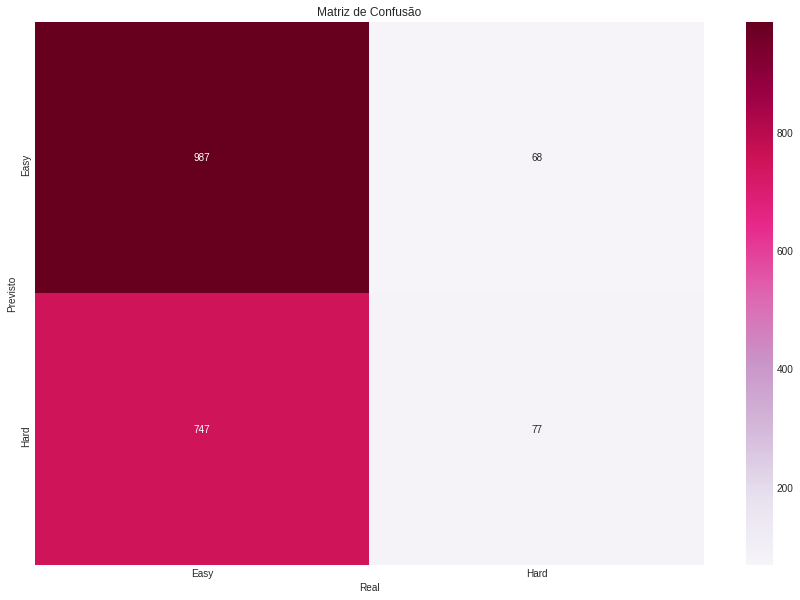

In [ ]:
predict_and_evaluate(X_test, y_test, 'under-random-forest.jpg')

## SVM

In [ ]:
model = trainSVM(X_rus, y_rus, seed)

Acurácia:  0.6652474720596062
Kappa:  0.00756236685456424
F1:  0.7416086471722311


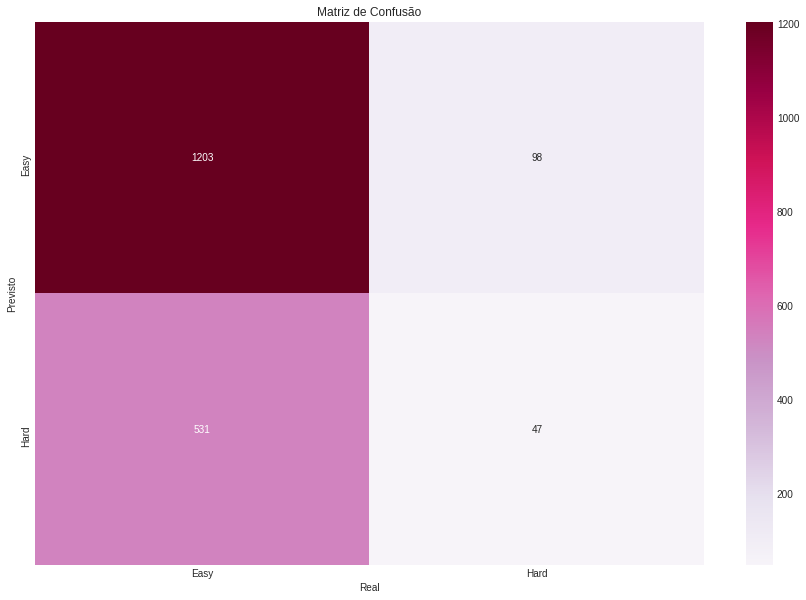

In [ ]:
predict_and_evaluate(X_test, y_test, 'under-svm.jpg')

## K Neighbors Classifier

In [ ]:
model = neigh(X_rus, y_rus, seed)

Acurácia:  0.5816923895689197
Kappa:  0.02210971961601982
F1:  0.6784124542472482


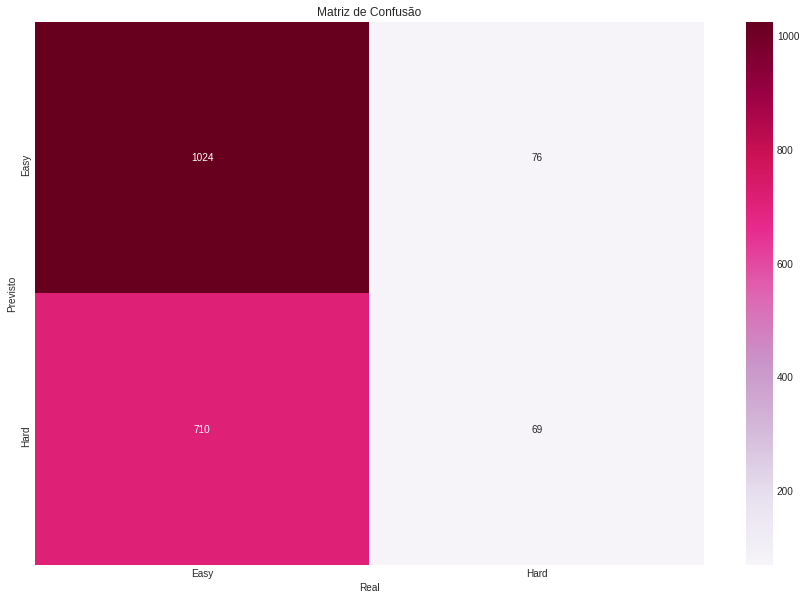

In [ ]:
predict_and_evaluate(X_test, y_test, 'under-k-neighbors.jpg')

**Conclusão**
<br><br>
Apesar do número total de amostras estar abaixo do ideal para a criação de um modelo preditivo, podemos observar que houve uma sutil melhora na performance de identificação da classe minoritária, mas ao custo da classificação da classe majoritária.
<br><br>
Dentro dessa proposta, o modelo que melhor performou foi o K Neighbors Classifier.

# K-Means

Método utilizado para problemas de classificação não supervisionados, em que os dados são segregados em torno de centróides. Método também identificado como clusterização.
<br><br>
Diante da ineficiência dos modelos em prever as classes de saída, optou-se por descartar o output e iniciar um estudo para encontrar similaridades entre a base de dados e realizar a atribuição de clusters.

## Método Elbow

O Método Elbow é utilizado para encontrar o valor ideal de clusters que melhor se adequa aos dados apresentados. O método aplica testes sobre a variância de dados em relacão ao número de clusters, e o valor ideal é obtido apartir do momento em que o aumento do número de clusters não representa um valor significativo de ganho.
<br><br>
Para este modelo, identificou-se que o número ideal de k (clusters) é igual a três.

1 3.3848061090924985e+26
2 8.11833538427884e+25
3 2.5664494237171727e+25
4 9.76065841207589e+24
5 4.461292623773187e+24
6 3.8568429919699686e+24
7 3.728702053590857e+24
8 3.3209393906884374e+24
9 1.5868208983064367e+24
10 1.310376706960615e+24


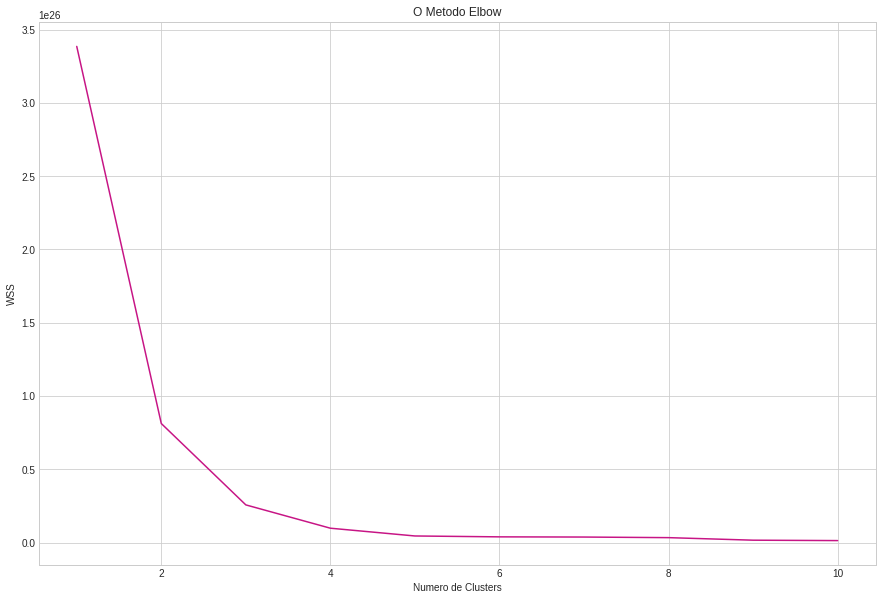

In [ ]:
from sklearn.cluster import KMeans

wcss = []
 
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X_PCA)
    print(i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 11), wcss, color='mediumvioletred')
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS')
# plt.savefig('metodo-elbow.png')
plt.show()

## Separando base original em três clusters

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'random')
kmeans.fit(X_PCA)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [ ]:
kmeans.cluster_centers_

array([[-1.27183788e+11,  3.39342191e+09],
       [ 2.46160108e+11,  2.62760458e+11],
       [ 2.02654222e+11, -6.85514768e+10]])

In [ ]:
distance = kmeans.transform(X_PCA)
distance

array([[3.84748053e+11, 3.09634300e+11, 5.09072243e+11],
       [3.84748078e+11, 3.09634341e+11, 5.09072286e+11],
       [3.60787523e+11, 3.26097181e+11, 2.54823507e+10],
       ...,
       [3.48025253e+11, 3.05546919e+11, 3.10870077e+10],
       [3.60915163e+11, 3.51986937e+11, 2.76145530e+10],
       [4.68002941e+09, 4.51051971e+11, 3.37436863e+11]])

In [ ]:
klabels = kmeans.labels_
klabels[0:100]

array([1, 1, 2, 2, 2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1,
       0, 1, 2, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 1,
       2, 2, 0, 0, 1, 0, 2, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0,
       1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 1,
       0, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2, 0], dtype=int32)

In [ ]:
print('Sum of labels %s' % Counter(klabels))

Sum of labels Counter({0: 5859, 2: 2862, 1: 671})


A distribuição da base de dado em três clusters ainda prevê a existência de uma classe minoritária, o que faz sentido dentro do contexto de trabalho do time de suporte.

## Plotando gráfico de distribuição

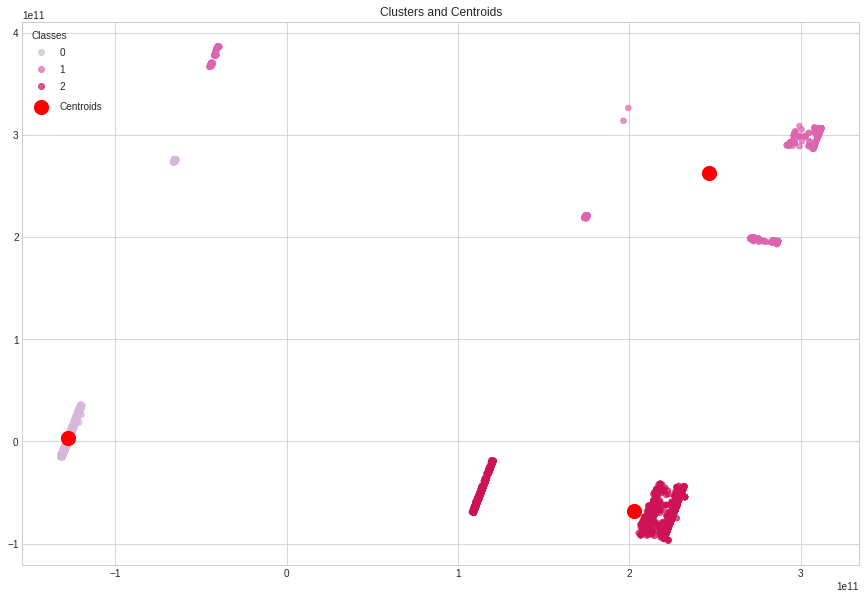

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_PCA.iloc[:, 0], X_PCA.iloc[:,1], s = 30, c = klabels, alpha=0.7, cmap='PuRd', vmin=-1, vmax=3)
centroids = plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 200, c = 'red', label='Centroids')
plt.title('Clusters and Centroids')

# Legenda classes
legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
plt.gca().add_artist(legend1)

plt.legend(handles=[centroids], loc='upper left', bbox_to_anchor=(0, 0.87))

# plt.savefig('cluster-centroids.png')
plt.show()

## Comparando divisão por clusters com classes de saída originais

In [ ]:
y_original = y['complexity'].replace({'low': 0, 'moderate': 1, 'high': 2, 'very_high':3})
y_original

0       2
1       3
2       3
3       1
4       2
       ..
9387    0
9388    0
9389    0
9390    1
9391    0
Name: complexity, Length: 9392, dtype: int64

In [ ]:
print('Sum of labels %s' % Counter(y_original))

Sum of labels Counter({0: 5821, 1: 2845, 2: 613, 3: 113})


In [ ]:
y_original = y_original.to_numpy()

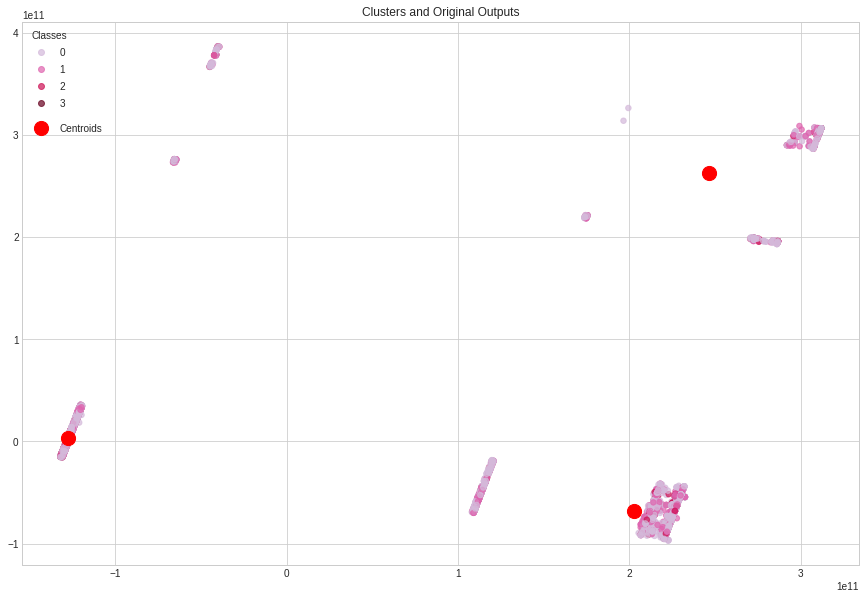

In [ ]:
fig, ax = plt.subplots()
scatter1 = ax.scatter(X_PCA.iloc[:, 0], X_PCA.iloc[:,1], s = 30, c = y_original, alpha= 0.7, cmap='PuRd', vmin=-1, vmax=3)
centroids1 = plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 200, c = 'red',label = 'Centroids')
plt.title('Clusters and Original Outputs')

# Legenda classes
legend2 = ax.legend(*scatter1.legend_elements(), loc="upper left", title="Classes")
plt.gca().add_artist(legend2)

plt.legend(handles=[centroids1], loc='upper left', bbox_to_anchor=(0, 0.83))

# plt.savefig('cluster-e-outputs.png')
plt.show()

Ao sobrepor os cluster propostos pelo Método Elbow e as classes de saída originais da base de dados, foi possível observar que não é possível extrair um padrão comportamental da distribuição.

# Considerações Finais

A proposta de realizar a predição da classe de saída dos chamados abertos junto ao time de suporte não pode ser alcançado. Identificou-se que a base utilizada para a solução do problema possui pouca correlação entre as variáveis e não trás insumos suficientes para a eficiência de um modelo de classificação. <br><br>
Podemos supor também que o número de amostras para as classes minoritárias não foi suficiente dado o grande desbalanceamento da base, e que novos dados, somados à base original, podem aumentar o desempenho da mesma.
<br><br>
É importante pontuar aqui também a necessidade de rever, não apenas o ajuste das classes (de quatro para três) como demonstrou o Método Elbow, para que exista ao final apenas uma classe do tipo rara, mas também a revisão dos parâmetros de classificação utilizados pelo time de suporte como um todo, implementando talvez Lógica Fuzzy para definir as classes utilizando variáveis linguísticas.